In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
import holidays
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from kerastuner import HyperModel, RandomSearch
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
%matplotlib inline

C:\Users\sakif\AppData\Local\Temp\ipykernel_27068\2700848507.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [2]:
# Load the weather and energy datasets
df = pd.read_csv("energy_data.csv", index_col="DateTime", parse_dates=True)
df = df[['Total (MW)']]
df.reset_index(inplace=True)


In [3]:
df['DateTime']=pd.to_datetime(df['DateTime']) 
df['year'] = df['DateTime'].apply(lambda x: x.year)
df['quarter'] = df['DateTime'].apply(lambda x: x.quarter)
df['month'] = df['DateTime'].apply(lambda x: x.month)
df['day'] = df['DateTime'].apply(lambda x: x.day)
df['hour'] = df['DateTime'].dt.hour
df.sort_values('DateTime', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['Working_day'] = np.where(df['dayofweek'].isin([0,1,2,3,6]), 1, 0)

In [4]:
# Define business hours in Bangladesh
business_hours_start = 9
business_hours_end = 17
lunch_break_start = 13
lunch_break_end = 14

# Define a function to check if a given time is within business hours
def is_business_hour(dt):
    if dt.weekday() in [0, 1, 2, 3, 6] and (business_hours_start <= dt.hour < business_hours_end) and not (lunch_break_start <= dt.hour < lunch_break_end):
        return 1
    else:
        return 0

# Apply the function to create the 'is_business_hour' feature
df['is_business_hour'] = df['DateTime'].apply(is_business_hour)

In [5]:
# Define peak hours in Bangladesh (e.g., 6-9 AM and 5-8 PM)
peak_hours_start1 = 6
peak_hours_end1 = 9
peak_hours_start2 = 17
peak_hours_end2 = 20

# Define a function to check if a given time is within peak hours
def is_peak_hour(dt):
    if (peak_hours_start1 <= dt.hour < peak_hours_end1) or (peak_hours_start2 <= dt.hour < peak_hours_end2):
        return 1
    else:
        return 0

# Apply the function to create the 'is_peak_hour' feature
df['is_peak_hour'] = df['DateTime'].apply(is_peak_hour)

# Create 'time_of_day' categorical feature
time_of_day_bins = [0, 6, 12, 18, 24]
time_of_day_labels = ['night', 'morning', 'afternoon', 'evening']
df['time_of_day'] = pd.cut(df['DateTime'].dt.hour, bins=time_of_day_bins, labels=time_of_day_labels, right=False, include_lowest=True)


In [6]:
df_c = df
df=df.loc[:,['DateTime', 'Total (MW)', 'year', 'quarter', 'month',
       'day', 'hour', 'dayofweek', 'Working_day', 'is_business_hour',
       'is_peak_hour', 'time_of_day']]

In [7]:
print(df.shape)
print(df.DateTime.min())
print(df.DateTime.max())

(43824, 12)
2018-01-01 00:00:00
2022-12-31 23:00:00


In [8]:
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Define a custom holiday calendar for Bangladesh
class BangladeshHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('International Mother Language Day', month=2, day=21),
        Holiday('Sheikh Mujibur Rahman\'s birthday', month=3, day=17),
        Holiday('Independence Day', month=3, day=26),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Eid al-Fitr', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('National Mourning Day', month=8, day=15),
        Holiday('Eid al-Adha', month=8, day=22, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Ashura', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Durga Puja', month=10, day=16, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Victory Day', month=12, day=16),
        Holiday('Christmas Day', month=12, day=25)
    ]

# Create a custom business day offset that excludes holidays in Bangladesh
bangladesh_busday = CustomBusinessDay(calendar=BangladeshHolidayCalendar())

# Create a new column 'Holiday' and initialize with 0
df['Holiday'] = 0

# Set the 'Holiday' column to 1 for the dates that are holidays in Bangladesh
for holiday in BangladeshHolidayCalendar().holidays(start='2018-01-01', end='2022-12-31'):
    df.loc[df['DateTime'].dt.date == holiday.date(), 'Holiday'] = 1
df

,DateTime,Total (MW),year,quarter,month,day,hour,dayofweek,Working_day,is_business_hour,is_peak_hour,time_of_day,Holiday
0,2018-01-01 00:00:00,5673.00,2018,1,1,1,0,0,1,0,0,night,1
1,2018-01-01 01:00:00,5183.00,2018,1,1,1,1,0,1,0,0,night,1
2,2018-01-01 02:00:00,4908.00,2018,1,1,1,2,0,1,0,0,night,1
3,2018-01-01 03:00:00,4786.00,2018,1,1,1,3,0,1,0,0,night,1
4,2018-01-01 04:00:00,4599.00,2018,1,1,1,4,0,1,0,0,night,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2022-12-31 19:00:00,9581.00,2022,4,12,31,19,5,0,0,1,evening,0
43820,2022-12-31 20:00:00,9396.00,2022,4,12,31,20,5,0,0,0,evening,0
43821,2022-12-31 21:00:00,9088.00,2022,4,12,31,21,5,0,0,0,evening,0
43822,2022-12-31 22:00:00,8697.00,2022,4,12,31,22,5,0,0,0,evening,0


       Total (MW)
count    43824.00
mean      8741.86
std       2043.45
min       1774.00
25%       7157.00
50%       8658.80
75%      10263.00
max      14782.00


NormaltestResult(statistic=array([2196.34195963]), pvalue=array([0.]))

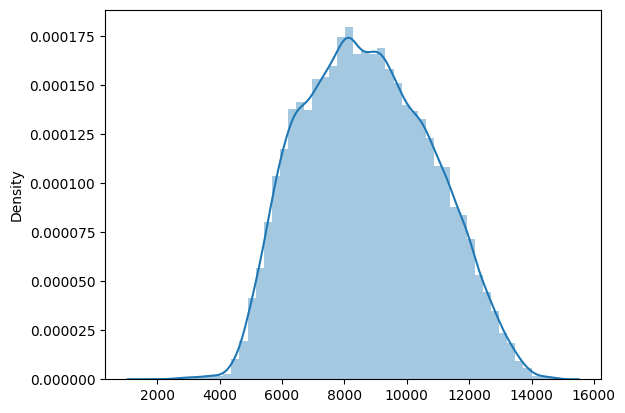

In [9]:
print(df[['Total (MW)']].describe())

sns.distplot(df[['Total (MW)']]);

stats.normaltest(df[['Total (MW)']])


In [10]:
#This function tests the null hypothesis that a sample comes from a normal distribution. 
# It is based on D'Agostino and Pearson's test that combines skew and kurtosis to produce
# an omnibus test of normality.
print( 'Kurtosis of normal distribution (should be 0): {}'.format(stats.kurtosis(df[['Total (MW)']])))
print( 'Skewness of normal distribution (should be 0): {}'.format(stats.skew(df[['Total (MW)']])))

Kurtosis of normal distribution (should be 0): [-0.67270326]
Skewness of normal distribution (should be 0): [0.15161643]


In [11]:
df1=df.loc[:,['DateTime','Total (MW)']]
#df1['Time'] = df['Time'].apply(lambda x: x.date())
#df1['Time']=pd.to_datetime(df1['Time'])
df1.set_index('DateTime',inplace=True);

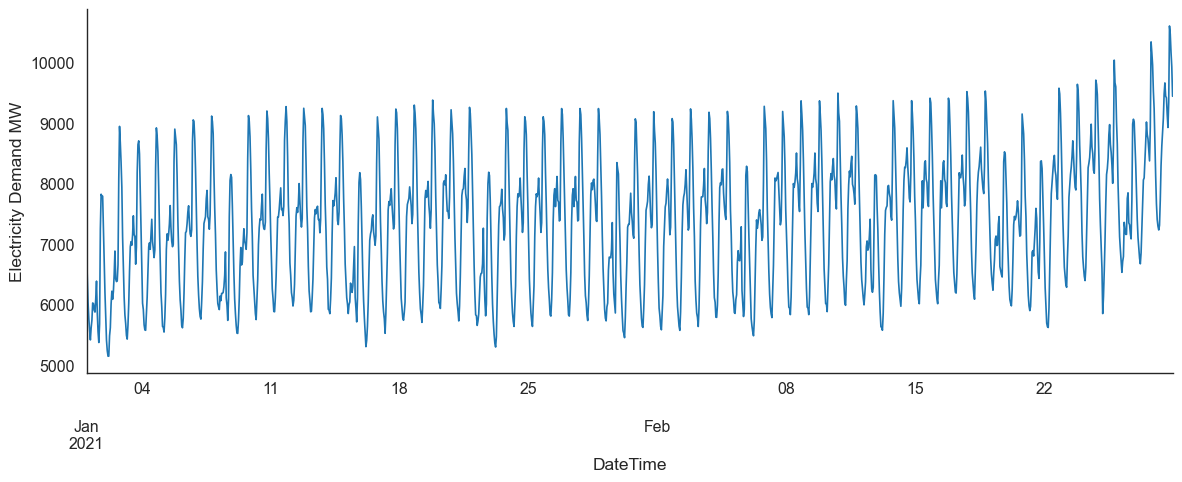

In [12]:
df2=df1[(df1.index>='2021-01-01') & (df1.index<'2021-03-01')]
#a=plt.figure(figsize=(15,6))
#sns.set_style("whitegrid", {'axes.grid' : False});
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
#a = fig.gca()  

df2.plot(figsize=(12,5));
#plt.tick_params(left=False, labelleft=True) #remove ticks
#plt.box(False)
plt.ylabel('Electricity Demand MW')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.savefig('Fig5.png', dpi=400) 
plt.show()

In [13]:

q = df['Total (MW)'].quantile(0.97)
dfq=df[df['Total (MW)'] < q]

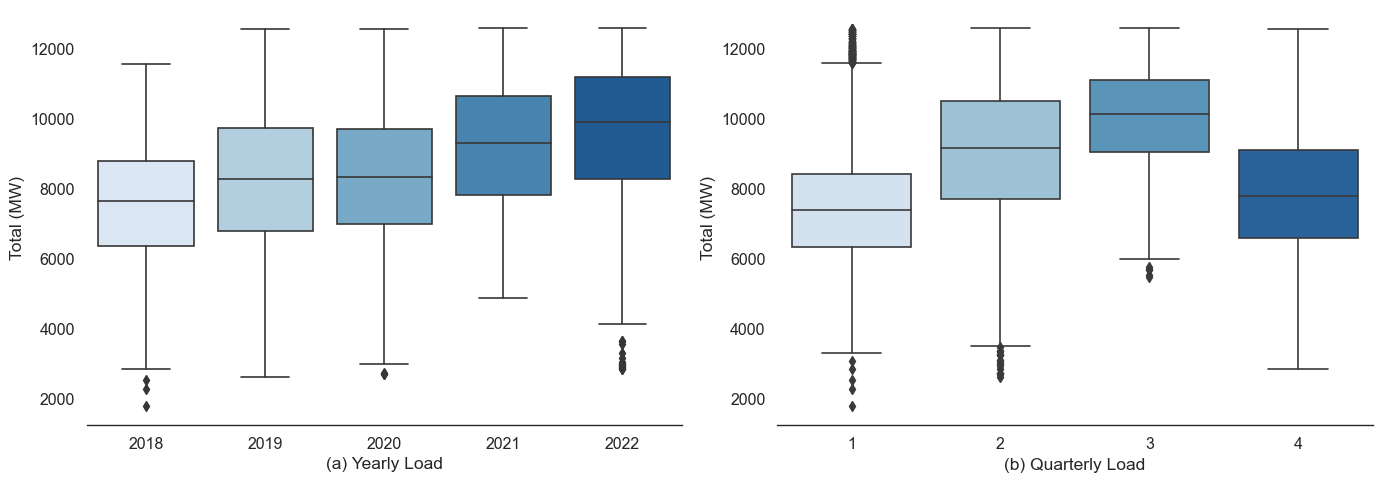

In [14]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
a=plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y='Total (MW)', data=dfq, palette='Blues');
plt.xlabel('(a) Yearly Load')
sns.despine(left=True);
plt.tight_layout() 

plt.subplot(1,2,2)

sns.boxplot(x="quarter", y='Total (MW)', data=dfq, palette='Blues');
plt.xlabel('(b) Quarterly Load')
sns.despine(left=True);
plt.tight_layout() 



#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
plt.savefig('Fig2.png', dpi=300)

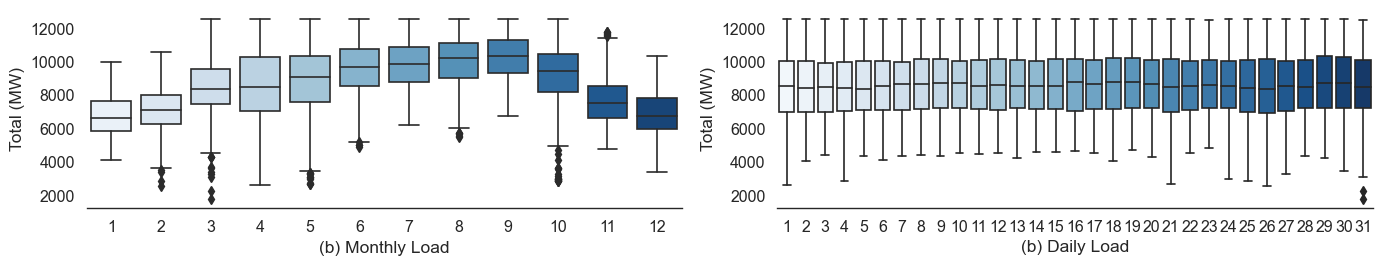

In [15]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
a=plt.figure(figsize=(14,5))
plt.subplot(2,2,1)

sns.boxplot(x="month", y='Total (MW)', data=dfq, palette='Blues');
plt.xlabel('(b) Monthly Load')
sns.despine(left=True);
plt.tight_layout() 

plt.subplot(2,2,2)

sns.boxplot(x="day", y='Total (MW)', data=dfq, palette='Blues');
plt.xlabel('(b) Daily Load')
sns.despine(left=True);
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Total (MW),43824.00,8741.86,2043.45,1774.00,7157.00,8658.80,10263.00,14782.00


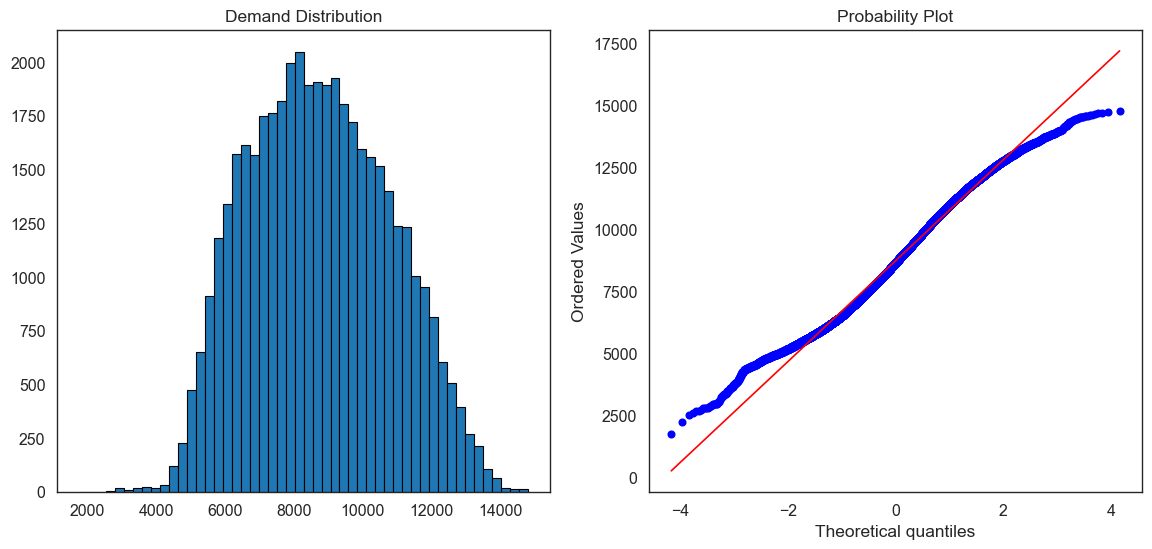

In [16]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Total (MW)'].hist(bins=50,edgecolor='black', grid=False)
plt.title('Demand Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Total (MW)'], plot=plt);
#print("Skewness: %f" % df['Consumption'].skew())
#print("Kurtosis: %f" % df['Consumption'].kurt())
df1.describe().transpose()

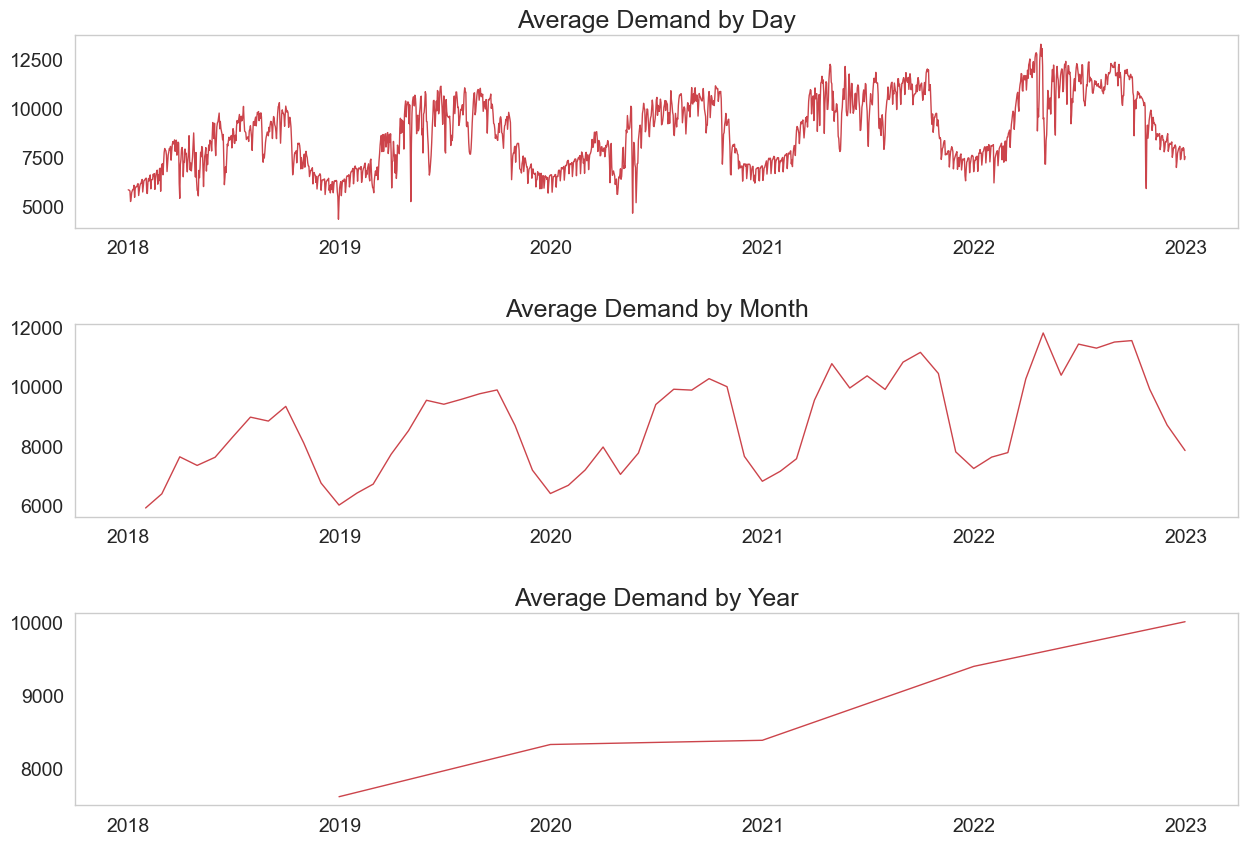

In [17]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=.5)
ax1 = fig.add_subplot(3,1,1)
ax1.plot(df1['Total (MW)'].resample('D').mean(),linewidth=1, color='#cc444b')
ax1.set_title('Average Demand by Day', fontsize=18)
#ax1.set_ylabel('Average Consumption', fontsize=14)
#ax1.set_xlabel('Day of Crime', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.plot(df1['Total (MW)'].resample('M').mean(),linewidth=1, color='#cc444b')
ax2.set_title('Average Demand by Month', fontsize=18)
#ax2.set_ylabel('# of Crimes', fontsize=14)
#ax2.set_xlabel('Month of Crime', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax3  = fig.add_subplot(3,1,3, sharex=ax1)
ax3.plot(df1['Total (MW)'].resample('A').mean(),linewidth=1, color='#cc444b')
ax3.set_title('Average Demand by Year', fontsize=18)
#ax3.set_ylabel('# of Crimes', fontsize=14)
#ax3.set_xlabel('Year of Crime', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)

Text(0.5, 0, 'Average Demand by Day')

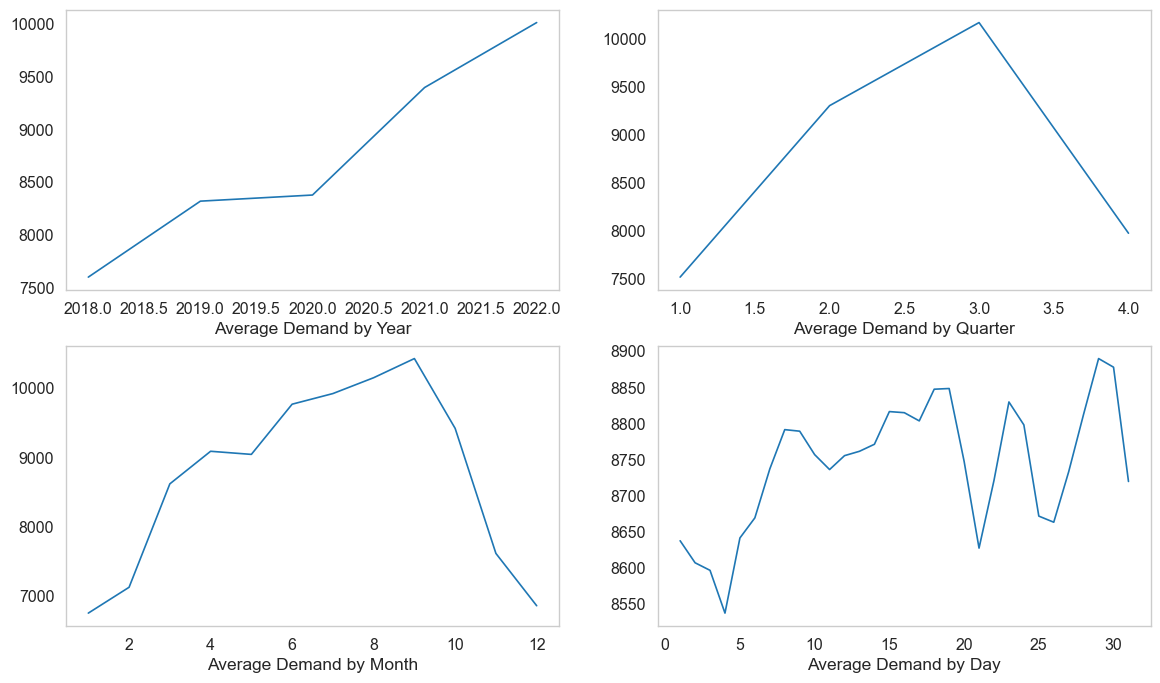

In [18]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year')['Total (MW)'].agg('mean').plot();
plt.xlabel('Average Demand by Year')

plt.subplot(2,2,2)
df.groupby('quarter')['Total (MW)'].agg('mean').plot();
plt.xlabel('Average Demand by Quarter')

plt.subplot(2,2,3)
df.groupby('month')['Total (MW)'].agg('mean').plot();
plt.xlabel('Average Demand by Month')

plt.subplot(2,2,4)
df.groupby('day')['Total (MW)'].agg('mean').plot();
plt.xlabel('Average Demand by Day')

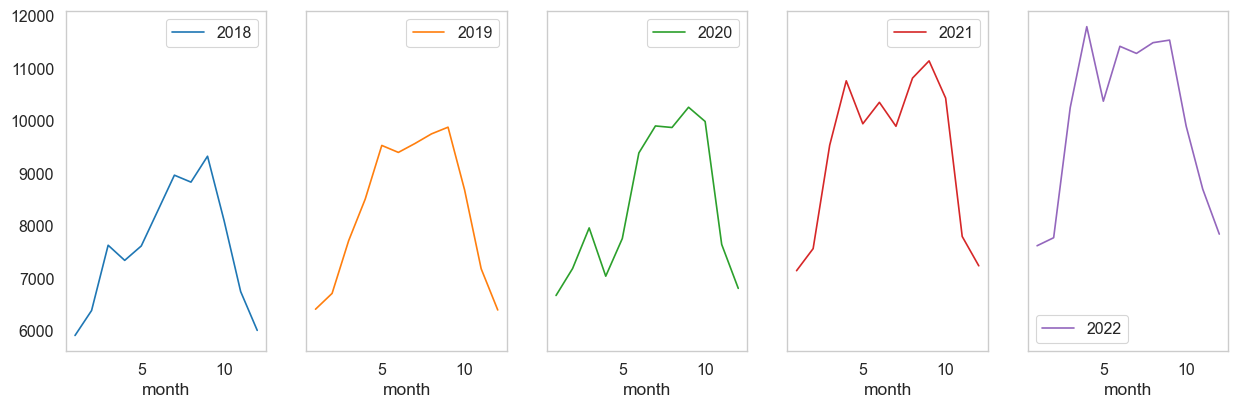

In [19]:
dfPivot = pd.pivot_table(df, values = "Total (MW)", 
                             columns = "year", index = "month")

dfPivot.plot(subplots = True, figsize=(15, 15), layout=(3, 5), sharey=True);

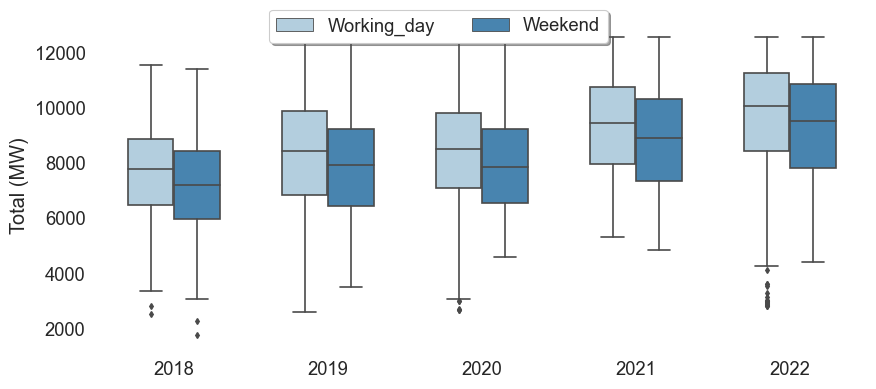

In [20]:
q = df["Total (MW)"].quantile(0.97)
dfq=df[df["Total (MW)"] < q]

dic={1:'Working_day',0:'Weekend'}
dfq['Day'] = dfq.Working_day.map(dic)

a=plt.figure(figsize=(9,4))
sns.set_context("paper", font_scale=1.5)  
plt1=sns.boxplot(x='year',y='Total (MW)',hue='Day',width=0.6,fliersize=3,
                    data=dfq, palette='Blues');                                                                                                                                                                                                                                                                                                                                             
#plt.title('Box Plot of Consumption by Weekend/Weekday')    
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False)
plt.savefig('Fig3.png', dpi=300)

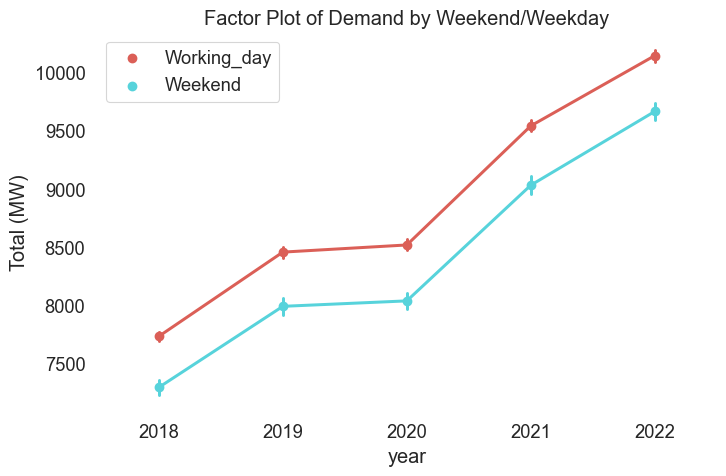

In [21]:
dic={1:'Working_day',0:'Weekend'}
df['Day'] = df.Working_day.map(dic)

sns.set_context("paper", font_scale=1.5)  
plt1=sns.catplot(x='year',y='Total (MW)',hue='Day',
                    data=df, kind='point', height=5, aspect=1.5, palette='hls', legend= False);                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Demand by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper left');

In [22]:
df2=df1.resample('D').mean()

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    #Plot rolling statistics:
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

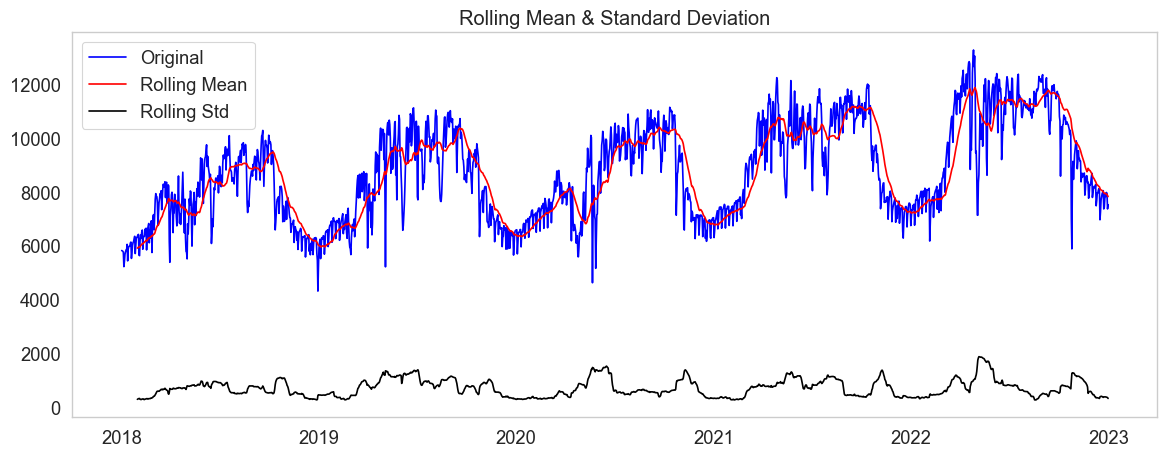

<Results of Dickey-Fuller Test>
Test Statistic                  -3.08
p-value                          0.03
#Lags Used                      21.00
Number of Observations Used   1804.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [23]:
test_stationarity(df2['Total (MW)'])

In [24]:
x= df['Total (MW)']
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range =(0 , 1))
x = np. array (x). reshape (( len(x), ))
x=np.log (x)
print (x.shape)#x is a 1 dimensional array with 157786 rows
x=x.reshape(-1 ,1)
print (x.shape)
x = scaler.fit_transform(x)
x=x.reshape (-1)
print (x.shape)
print(round(x.min(),2))
print(round(x.max(),2))
from statsmodels.tsa.stattools import pacf
x_pacf=pacf (x,nlags=20, method='ols')
print (x_pacf)

(43824,)
(43824, 1)
(43824,)
0.0
1.0
[ 1.          0.97270082 -0.45491255  0.05591275  0.00231074  0.05496489
  0.04213237  0.03794433  0.09485096  0.06404306  0.02566668  0.0252147
  0.06596854 -0.00763508  0.11912818  0.04913952  0.14784737  0.16204236
  0.14825978  0.14704081  0.20427668]


In [25]:
#df2 = df1['Consumption'].resample('D').mean().to_frame()
tslog=np.log(df1)
#tslog = tslog - tslog.shift(1)
#tslog=tslog+10
tslog.dropna(inplace=True)
tslog[tslog['Total (MW)']<0].count()

Total (MW)    0
dtype: int64

In [26]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#df1diff.head()
tslog.dropna(inplace=True)
test_stationarity(tslog['Total (MW)'])

<Results of Dickey-Fuller Test>
Test Statistic                   -7.18
p-value                           0.00
#Lags Used                       55.00
Number of Observations Used   43768.00
Critical Value (1%)              -3.43
Critical Value (5%)              -2.86
Critical Value (10%)             -2.57
dtype: float64


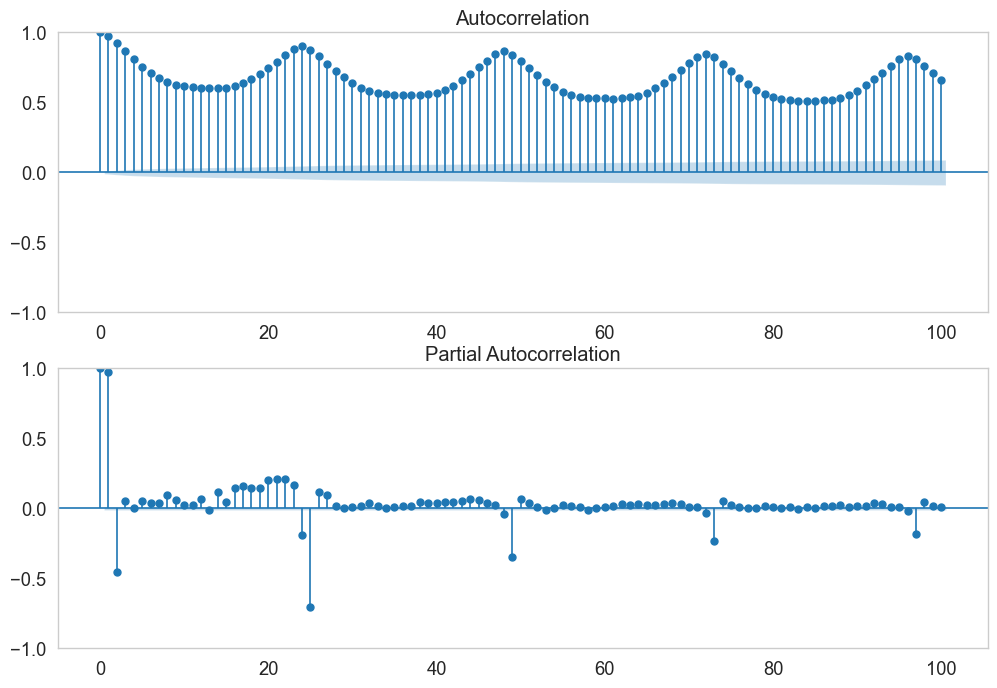

In [27]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tslog.iloc[13:], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tslog.iloc[13:], lags=100, ax=ax2)
plt.savefig('Fig33.png', dpi=400)

In [28]:
df_c.set_index('DateTime', inplace = True)

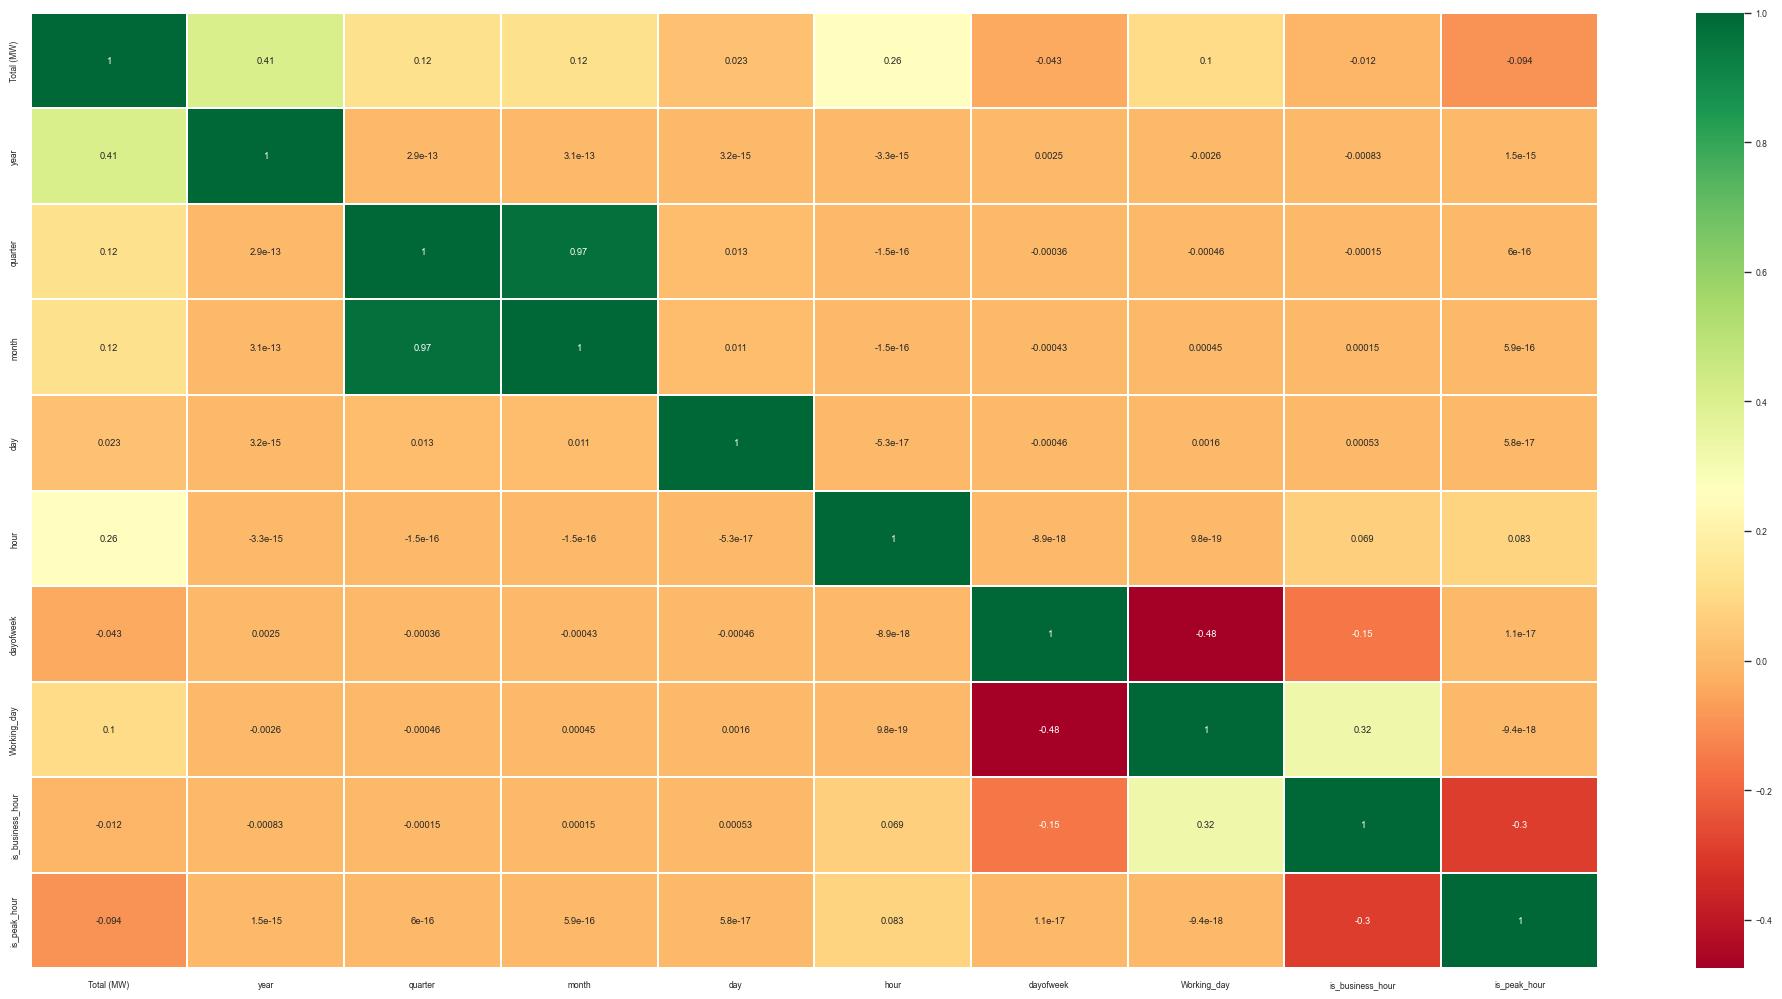

In [29]:
sns.set_style('white')
sns.set_context("paper", font_scale=0.7)  
plt.figure(figsize=(20,10))
sns.heatmap(df_c.corr(), annot=True, cmap='RdYlGn', linewidths=0.1)
plt.tight_layout()

#### Appending 30 Previous Time Lags ####


In [30]:
for obs in range(1,25):
    df_c["T_" + str(obs)] = df_c['Total (MW)'].shift(obs)
    
#df.fillna(0.00,inplace=True)
df_c.head(3)  

,Total (MW),year,quarter,month,day,hour,dayofweek,Working_day,is_business_hour,is_peak_hour,...,T_15,T_16,T_17,T_18,T_19,T_20,T_21,T_22,T_23,T_24
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,5673.00,2018,1,1,1,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,5183.00,2018,1,1,1,1,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,4908.00,2018,1,1,1,2,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
df_c=df_c.dropna()

In [32]:
for obs in range(1,366):
    df1["T_" + str(obs)] = df1['Total (MW)'].shift(obs)
    
#df.fillna(0.00,inplace=True)
df1.head(3)  

,Total (MW),T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,...,T_356,T_357,T_358,T_359,T_360,T_361,T_362,T_363,T_364,T_365
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,5673.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,5183.00,5673.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,4908.00,5183.00,5673.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df1=df1.dropna()
df1.shape

(43459, 366)

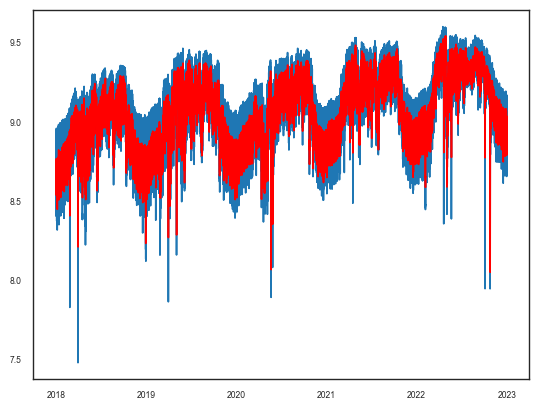

In [34]:
moving_avg = tslog.rolling(window=12).mean()
plt.plot(tslog)
plt.plot(moving_avg, color='red')

In [35]:
df2=df.loc[:,['DateTime','Total (MW)']]
#df1['Time'] = df['Time'].apply(lambda x: x.date())
#df1['Time']=pd.to_datetime(df1['Time'])
df2.set_index('DateTime',inplace=True);

In [36]:
ma = df2.rolling(window=12).mean()
ma= ma.replace(0,np.NAN)
ma=ma.dropna(how='all',axis=0)
ma.head()

,Total (MW)
DateTime,
2018-01-01 11:00:00,5232.42
2018-01-01 12:00:00,5243.42
2018-01-01 13:00:00,5300.58
2018-01-01 14:00:00,5355.75
2018-01-01 15:00:00,5421.25


In [37]:
df3=df2
df3.head()

,Total (MW)
DateTime,
2018-01-01 00:00:00,5673.00
2018-01-01 01:00:00,5183.00
2018-01-01 02:00:00,4908.00
2018-01-01 03:00:00,4786.00
2018-01-01 04:00:00,4599.00


In [38]:
# Extract time-lag features for 1 day, 2 day, 3 day, 5 day, 1 week, 2 week, and a month ago
for days_to_lag in [1, 2, 3, 5, 7, 14, 30]:
    df3['Demand_lag_{}'.format(days_to_lag)] = df3['Total (MW)'].shift(days_to_lag)

In [39]:
df3.isnull().sum()

Total (MW)        0
Demand_lag_1      1
Demand_lag_2      2
Demand_lag_3      3
Demand_lag_5      5
Demand_lag_7      7
Demand_lag_14    14
Demand_lag_30    30
dtype: int64

In [40]:
df3.dropna(inplace=True)
df3.shape,df2.shape


((43794, 8), (43794, 8))

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

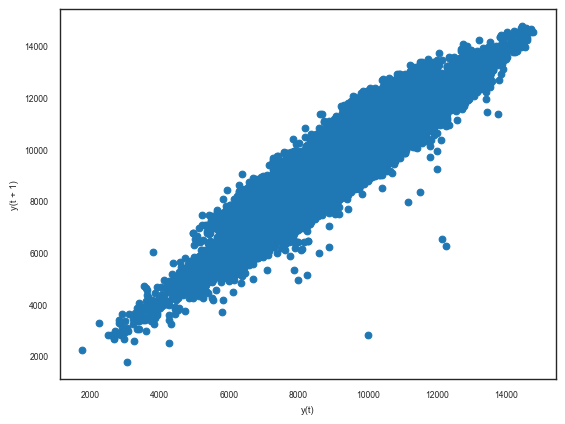

In [41]:
pd.plotting.lag_plot(df3['Total (MW)'],lag =1)

<Axes: xlabel='y(t)', ylabel='y(t + 24)'>

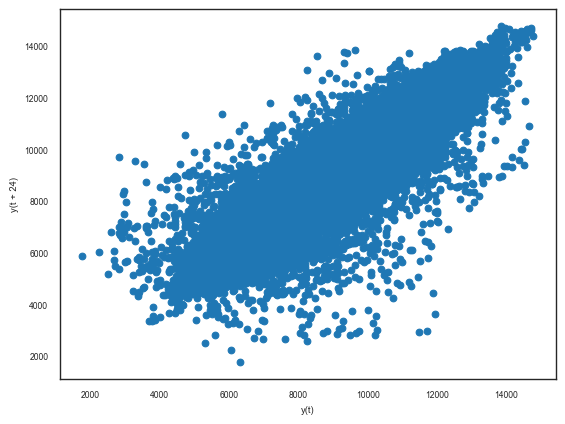

In [42]:
pd.plotting.lag_plot(df3['Total (MW)'],lag =24)

<Axes: xlabel='y(t)', ylabel='y(t + 168)'>

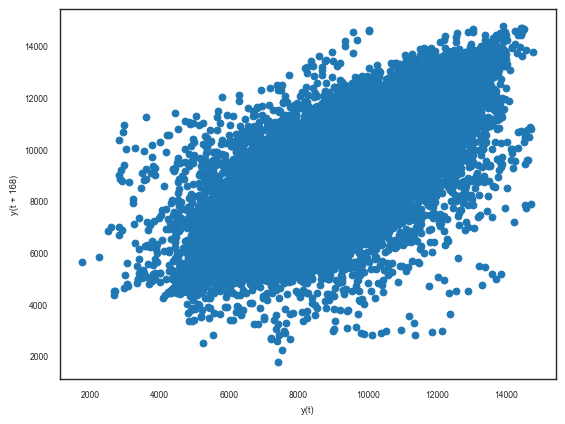

In [43]:
pd.plotting.lag_plot(df3['Total (MW)'],lag =168)

<Axes: xlabel='y(t)', ylabel='y(t + 8640)'>

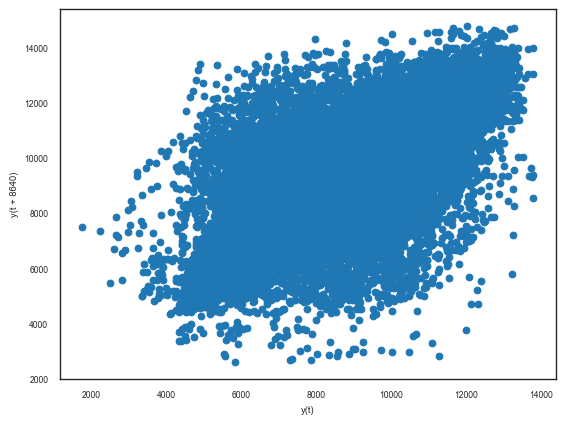

In [44]:
pd.plotting.lag_plot(df3['Total (MW)'],lag =8640)

<Axes: xlabel='y(t)', ylabel='y(t + 4320)'>

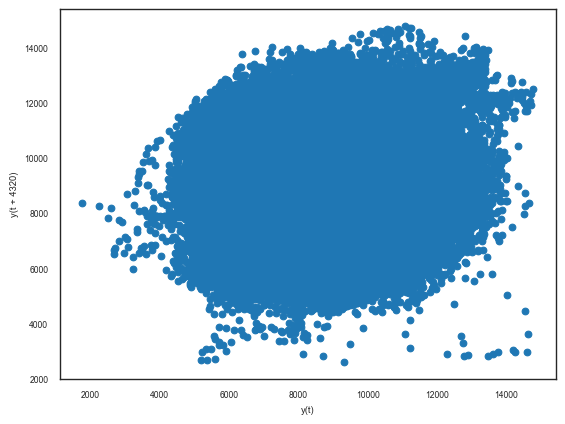

In [45]:
pd.plotting.lag_plot(df3['Total (MW)'],lag =4320)

<Axes: xlabel='y(t)', ylabel='y(t + 2150)'>

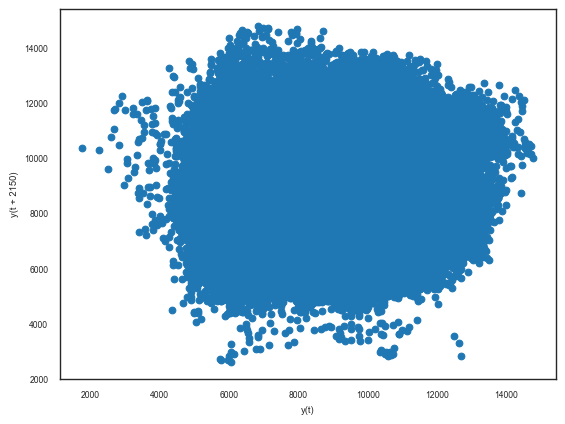

In [46]:
pd.plotting.lag_plot(df3['Total (MW)'],lag =2150)

In [47]:
df_acp = df.copy()
df_acp.set_index('DateTime', inplace = True)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

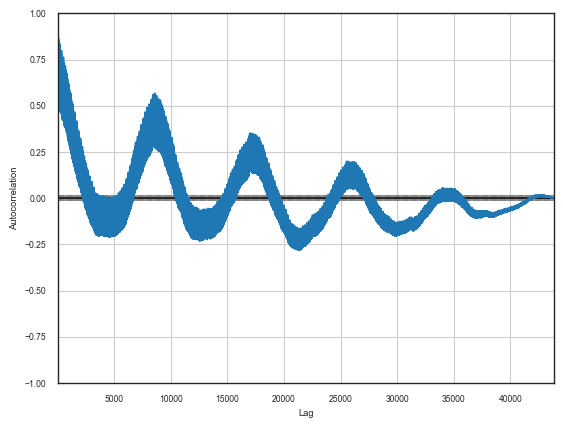

In [48]:
pd.plotting.autocorrelation_plot(df_acp['2018':'2022']['Total (MW)'])

In [49]:
df_acp_m = df_acp['Total (MW)'].resample("1m").mean()
df_acp_d = df_acp['Total (MW)'].resample("1d").mean()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

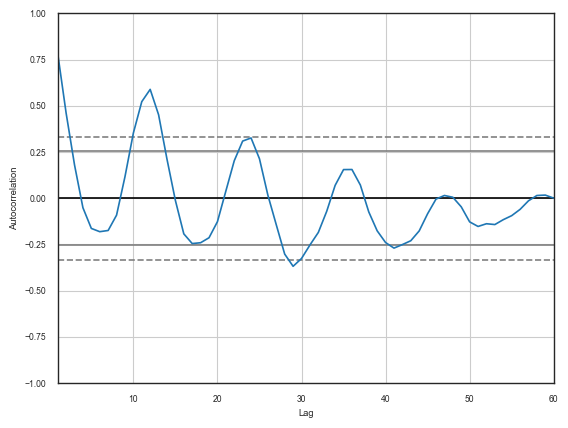

In [50]:
pd.plotting.autocorrelation_plot(df_acp_m)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

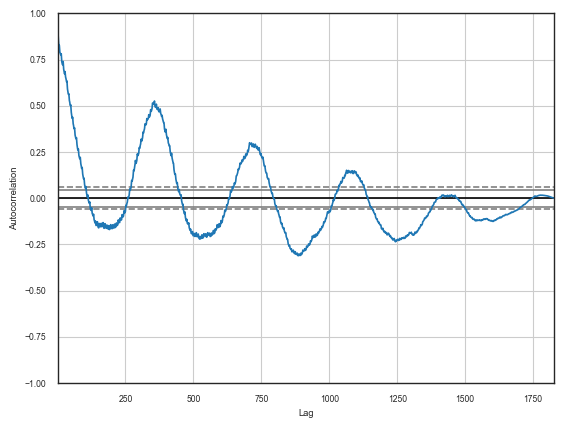

In [51]:
pd.plotting.autocorrelation_plot(df_acp_d)

In [52]:
df_c

,Total (MW),year,quarter,month,day,hour,dayofweek,Working_day,is_business_hour,is_peak_hour,...,T_15,T_16,T_17,T_18,T_19,T_20,T_21,T_22,T_23,T_24
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,5551.00,2018,1,1,2,0,1,1,0,0,...,5927.00,5595.00,5191.00,4862.00,4594.00,4599.00,4786.00,4908.00,5183.00,5673.00
2018-01-02 01:00:00,5040.00,2018,1,1,2,1,1,1,0,0,...,5720.00,5927.00,5595.00,5191.00,4862.00,4594.00,4599.00,4786.00,4908.00,5183.00
2018-01-02 02:00:00,4679.00,2018,1,1,2,2,1,1,0,0,...,5751.00,5720.00,5927.00,5595.00,5191.00,4862.00,4594.00,4599.00,4786.00,4908.00
2018-01-02 03:00:00,4596.00,2018,1,1,2,3,1,1,0,0,...,5805.00,5751.00,5720.00,5927.00,5595.00,5191.00,4862.00,4594.00,4599.00,4786.00
2018-01-02 04:00:00,4492.00,2018,1,1,2,4,1,1,0,0,...,5869.00,5805.00,5751.00,5720.00,5927.00,5595.00,5191.00,4862.00,4594.00,4599.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,9581.00,2022,4,12,31,19,5,0,0,1,...,5838.00,6065.00,6154.00,6588.00,7015.00,7622.00,8224.00,8354.00,8634.00,8641.00
2022-12-31 20:00:00,9396.00,2022,4,12,31,20,5,0,0,0,...,5746.00,5838.00,6065.00,6154.00,6588.00,7015.00,7622.00,8224.00,8354.00,8634.00
2022-12-31 21:00:00,9088.00,2022,4,12,31,21,5,0,0,0,...,5923.00,5746.00,5838.00,6065.00,6154.00,6588.00,7015.00,7622.00,8224.00,8354.00


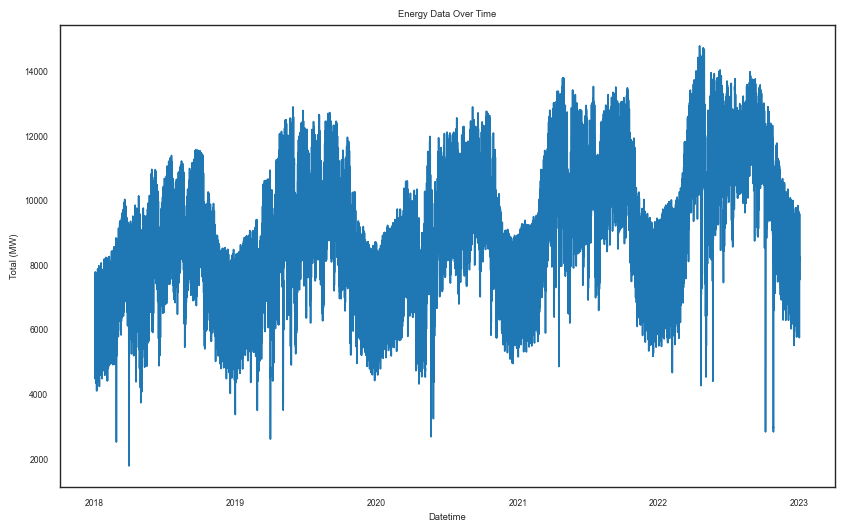

In [53]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_c.reset_index(),  x='DateTime', y='Total (MW)')
plt.xlabel('Datetime')
plt.ylabel('Total (MW)')
plt.title('Energy Data Over Time')
plt.show()

<Figure size 1200x800 with 0 Axes>

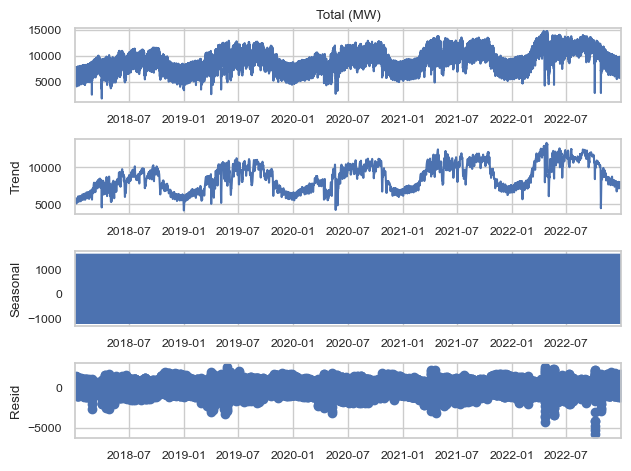

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


# decompose the data
result = seasonal_decompose(df_c['Total (MW)'], model='additive', period=24)

# plot the decomposition
sns.set(font_scale=0.8)

# set the figure size and style
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))

result.plot()
plt.show()


## k-means Clustering ##

In [55]:

# Prepare the dataset for clustering
daily_data = df.pivot_table(values='Total (MW)', index=df['DateTime'].dt.date, columns=df['DateTime'].dt.hour)

# Normalize the data
scaler = StandardScaler()
daily_data_scaled = scaler.fit_transform(daily_data)

# Determine the optimal number of clusters
cluster_range = range(2, 11)  # Test different numbers of clusters, e.g., from 2 to 10
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(daily_data_scaled)
    silhouette_avg = silhouette_score(daily_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]

# Fit the k-means clustering algorithm with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
daily_data['cluster'] = kmeans.fit_predict(daily_data_scaled)
labels = kmeans.labels_
daily_data['cluster'] = labels
labels = kmeans.labels_

# Add a column with cluster labels to the original dataset
daily_data['cluster'] = labels

# Investigate the characteristics of each cluster
for cluster in range(optimal_clusters):
    cluster_days = daily_data[daily_data['cluster'] == cluster]
    print(f"Cluster {cluster}: {len(cluster_days)} days")
    print(cluster_days.describe().transpose())
    print()


Cluster 0: 995 days
          count    mean     std     min     25%     50%     75%      max
DateTime                                                                
0        995.00 7527.41 1327.64 3033.00 6585.50 7323.00 8341.00 13923.00
1        995.00 7042.49 1315.75 2983.00 6087.00 6807.00 7810.00 13476.00
2        995.00 6729.37 1287.35 2883.00 5799.00 6475.00 7493.00 12633.00
3        995.00 6522.49 1261.06 2828.00 5642.50 6270.00 7256.00 11905.00
4        995.00 6329.93 1210.63 2857.00 5483.00 6074.00 7025.00 10697.00
5        995.00 6178.06 1125.47 2515.00 5420.00 5983.00 6893.50 10103.00
6        995.00 6171.86  899.28 2679.20 5598.00 6090.00 6762.55  9610.00
7        995.00 6369.70  820.03 1774.00 5870.20 6404.70 6920.50  9533.00
8        995.00 6695.31  810.21 2256.00 6186.70 6767.02 7252.50  9683.00
9        995.00 6957.69  860.57 3286.00 6395.09 7035.00 7567.70  9694.00
10       995.00 7044.97  903.91 3538.40 6397.70 7118.90 7738.20  9923.00
11       995.00 7176.18  933.02

Based on the provided output, we can observe the following characteristics for the two clusters:

**Cluster 0:**

This cluster has 995 days.

The mean electricity load demand in this cluster is generally lower compared to Cluster 1 across all hours of the day.

The minimum and maximum loads are also lower compared to Cluster 1.


**Cluster 1:**

This cluster has 831 days.

The mean electricity load demand in this cluster is generally higher compared to Cluster 0 across all hours of the day.

The minimum and maximum loads are also higher compared to Cluster 0.

From these characteristics, we can infer that Cluster 0 represents days with relatively lower electricity demand, while Cluster 1 represents days with higher electricity demand. The differences in demand levels may be attributed to various factors, such as:

**Seasonal patterns:** There could be seasonal differences, with Cluster 0 representing days in the cooler months when energy consumption for cooling is lower, and Cluster 1 representing days in the hotter months when energy consumption for cooling is higher.

**Days of the week:** Cluster 0 might be capturing weekends or holidays, when electricity demand is generally lower due to reduced industrial and commercial activities. In contrast, Cluster 1 could represent weekdays, when electricity demand is higher.

**Weather conditions:** The difference between the two clusters could be influenced by variations in weather conditions, with Cluster 0 corresponding to days with milder temperatures and Cluster 1 representing days with extreme temperatures, leading to increased energy consumption for heating or cooling.

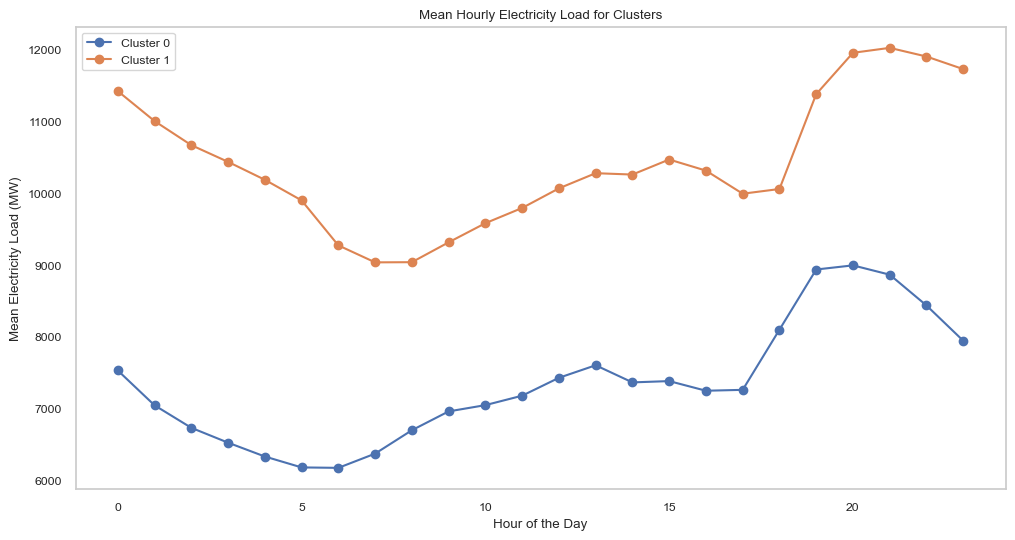

In [56]:
import matplotlib.pyplot as plt

# Calculate the mean hourly load demand for each cluster
cluster_mean_load = daily_data.groupby('cluster').mean()

# Create a plot comparing the mean hourly load demand for each cluster
plt.figure(figsize=(12, 6))
plt.plot(cluster_mean_load.columns, cluster_mean_load.loc[0], label='Cluster 0', marker='o')
plt.plot(cluster_mean_load.columns, cluster_mean_load.loc[1], label='Cluster 1', marker='o')

plt.xlabel('Hour of the Day')
plt.ylabel('Mean Electricity Load (MW)')
plt.title('Mean Hourly Electricity Load for Clusters')
plt.legend()
plt.grid()
plt.show()


In [57]:
daily_data['cluster'] = labels

# Convert the index to DatetimeIndex
daily_data.index = pd.to_datetime(daily_data.index)

# Define the function to get the season based on the month
def get_season(month):
    if month in [2, 3, 4, 5]:
        return 'Irrigation'
    elif month in [4, 5, 6, 7]:
        return 'Summer'
    elif month in [12, 1, 2]:
        return 'Winter'
    elif month in [6, 7, 8, 9]:
        return 'Business'

# Extract the month from the 'DateTime' column
daily_data['month'] = daily_data.index.month

# Create a 'season' column based on the month
daily_data['season'] = daily_data.index.month.map(get_season)

# Create a custom business day offset that excludes holidays in Bangladesh
bangladesh_busday = CustomBusinessDay(calendar=BangladeshHolidayCalendar())

# Create a new column 'Holiday' and initialize with 0
daily_data['Holiday'] = 0

# Set the 'Holiday' column to 1 for the dates that are holidays in Bangladesh
for holiday in BangladeshHolidayCalendar().holidays(start='2018-01-01', end='2022-12-31'):
    daily_data.loc[daily_data.index.date == holiday.date(), 'Holiday'] = 1

In [58]:
# Analyze the distribution of days within each cluster across months
monthly_distribution = daily_data.groupby(['cluster', 'month']).size().unstack()
print("Distribution of days across months:")
print(monthly_distribution)

# Analyze the distribution of days within each cluster across weekdays and weekends
daily_data['weekday'] = daily_data.index.weekday
daily_data['weekend'] = daily_data['weekday'].apply(lambda x: 1 if x in ([0,1,2,3,6]) else 0)
weekend_distribution = daily_data.groupby(['cluster', 'weekend']).size().unstack()
print("\nDistribution of days across weekdays and weekends:")
print(weekend_distribution)

# Analyze the distribution of days within each cluster across seasons
season_distribution = daily_data.groupby(['cluster', 'season']).size().unstack()
print("Distribution of days across seasons:")
print(season_distribution)

# Analyze the distribution of days within each cluster across holidays
holiday_distribution = daily_data.groupby(['cluster', 'Holiday']).size().unstack()
print("\nDistribution of days across holidays:")
print(holiday_distribution)



Distribution of days across months:
month       1      2      3     4     5      6      7      8      9      10  \
cluster                                                                       
0       155.00 140.00 101.00 80.00 71.00  40.00  31.00  24.00  11.00  49.00   
1          NaN   1.00  54.00 70.00 84.00 110.00 124.00 131.00 139.00 106.00   

month       11     12  
cluster                
0       138.00 155.00  
1        12.00    NaN  

Distribution of days across weekdays and weekends:
weekend    0    1
cluster          
0        313  682
1        209  622
Distribution of days across seasons:
season   Business  Irrigation  Summer  Winter
cluster                                      
0           35.00      392.00   71.00  310.00
1          270.00      209.00  234.00     NaN

Distribution of days across holidays:
Holiday    0   1
cluster         
0        959  36
1        812  19


Based on the results, we can infer the following:

**Distribution of days across months:**

Cluster 0 is more frequent in months 1, 2, 11, and 12, with the highest occurrences in January (155) and December (155).

Cluster 1 is more frequent from March to September, peaking in July (124) and August (131).

Cluster 1 is almost absent in January and December.


**Distribution of days across weekdays and weekends:**

Cluster 0 has 313 occurrences on weekdays and 682 on weekends.

Cluster 1 has 209 occurrences on weekdays and 622 on weekends.

Both clusters occur more frequently on weekends than weekdays, with Cluster 0 being slightly more prevalent on weekends compared to Cluster 1.


**Distribution of days across seasons:**

Cluster 0 is most frequent in the Irrigation season (392) and Winter (310), while it is less frequent in Business (35) and Summer (71) seasons.

Cluster 1 is most frequent in the Business (270) and Summer (234) seasons, while it is less frequent in the Irrigation season (209). Cluster 1 is not present in Winter.

The seasonality of each cluster is distinct, with Cluster 0 being more common during the Irrigation and Winter seasons, and Cluster 1 during the Business and Summer seasons.


**Distribution of days across holidays:**

Cluster 0 has 959 occurrences on non-holidays and 36 on holidays.

Cluster 1 has 812 occurrences on non-holidays and 19 on holidays.

Both clusters are more frequent on non-holidays than on holidays. The difference in occurrences on holidays and non-holidays is more significant in Cluster 1.

In conclusion, Cluster 0 is more common during the Irrigation and Winter seasons, with a higher frequency on weekends and non-holidays. Cluster 1 is more common during the Business and Summer seasons, also with a higher frequency on weekends and non-holidays. However, the difference between holidays and non-holidays is more prominent in Cluster 1.

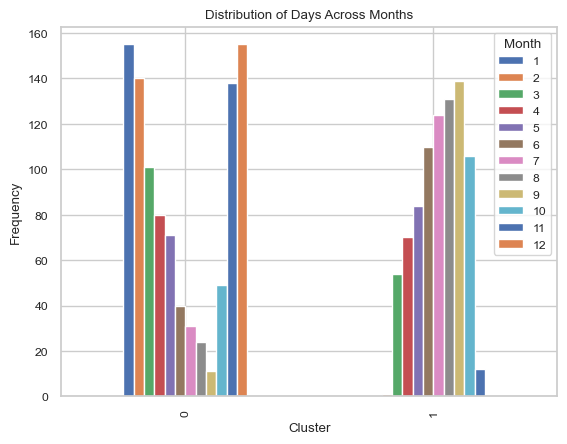

In [59]:
monthly_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Months')
plt.legend(title='Month')
plt.show()


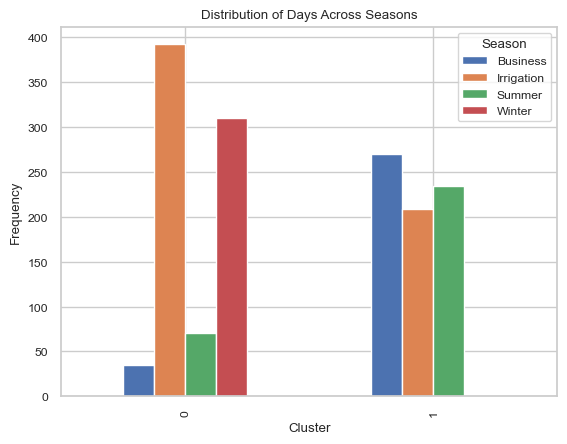

In [60]:
season_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Seasons')
plt.legend(title='Season')
plt.show()


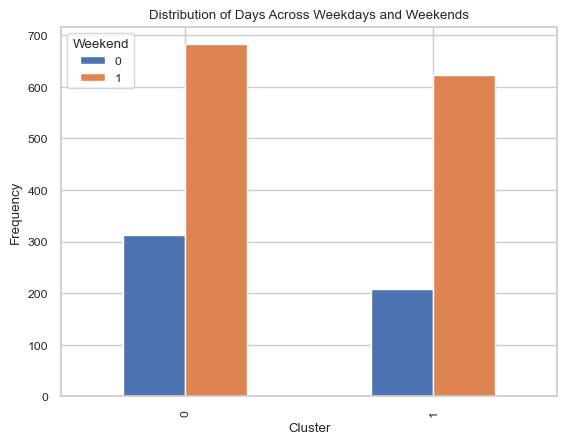

In [61]:
weekend_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Weekdays and Weekends')
plt.legend(title='Weekend')
plt.show()


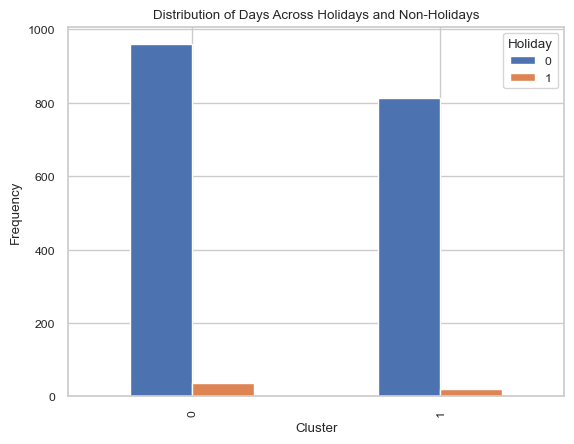

In [62]:
holiday_distribution.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Days Across Holidays and Non-Holidays')
plt.legend(title='Holiday')
plt.show()


In [63]:
daily_data

DateTime,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,cluster,month,season,Holiday,weekday,weekend
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,5673.00,5183.00,4908.00,4786.00,4599.00,4594.00,4862.00,5191.00,5595.00,5927.00,...,7483.00,7206.00,6609.00,6171.00,0,1,Winter,1,0,1
2018-01-02,5551.00,5040.00,4679.00,4596.00,4492.00,4472.00,4713.00,5111.00,5653.00,5806.00,...,7676.00,7282.00,6732.00,5921.00,0,1,Winter,1,1,1
2018-01-03,5455.00,5130.00,4789.00,4730.00,4483.00,4539.00,4740.00,5066.00,5533.00,5928.00,...,7707.00,7467.00,6689.00,5846.00,0,1,Winter,0,2,1
2018-01-04,5412.00,4926.00,4657.00,4510.00,4417.00,4336.00,4609.00,4920.00,5418.00,5954.00,...,7608.00,7281.00,6561.00,6116.00,0,1,Winter,0,3,1
2018-01-05,5486.00,4977.00,4738.00,4545.00,4405.00,4345.00,4505.00,4620.00,4837.00,5130.00,...,6825.00,6681.00,6034.00,5486.00,0,1,Winter,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,7680.00,7250.00,6792.00,6516.00,6142.00,5993.00,6171.00,5809.00,6480.00,7346.00,...,9588.00,9259.00,8798.00,8479.00,0,12,Winter,0,1,1
2022-12-28,7850.00,7168.00,6843.00,6655.00,6303.00,6214.00,6306.00,6666.00,7472.00,8004.00,...,9511.00,9254.00,8819.00,8199.00,0,12,Winter,0,2,1
2022-12-29,7705.00,7086.00,6657.00,6418.00,6181.00,6154.00,6368.00,6891.00,7346.00,7894.00,...,9545.00,8816.00,8565.00,8289.00,0,12,Winter,0,3,1


In [64]:
# Remove the 'DateTime' index name
daily_data.index.name = None

# Convert the 'season' column to a one-hot encoding format
daily_data = pd.get_dummies(daily_data, columns=['season'], prefix='season')

In [65]:
# Preprocess the data
scaler = StandardScaler()
daily_data_scaled = scaler.fit_transform(daily_data)

# Split the data into training and validation sets
X_train, X_val, train_idx, val_idx = train_test_split(daily_data_scaled, np.arange(daily_data.shape[0]), test_size=0.2, random_state=42)

# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 32  # You can change this value according to your problem

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and train the model
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_val, X_val))

# Reconstruct the data and calculate the reconstruction errors
X_train_pred = autoencoder.predict(X_train)
X_val_pred = autoencoder.predict(X_val)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_val = np.mean(np.power(X_val - X_val_pred, 2), axis=1)

# Determine the threshold for anomalies
threshold = np.percentile(np.concatenate([mse_train, mse_val]), 99)  # 99th percentile

# Detect anomalies
train_anomalies = X_train[mse_train > threshold]
val_anomalies = X_val[mse_val > threshold]


print("Number of anomalies in the training set:", len(train_anomalies))
print("Number of anomalies in the validation set:", len(val_anomalies))


Epoch 1/100
46/46 [==============================] - 1s 6ms/step - loss: 0.9784 - val_loss: 0.5763
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.4456 - val_loss: 0.3031
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 0.2645 - val_loss: 0.2100
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.1973 - val_loss: 0.1658
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.1593 - val_loss: 0.1340
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.1309 - val_loss: 0.1099
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.1093 - val_loss: 0.0921
Epoch 8/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0931 - val_loss: 0.0780
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0808 - val_loss: 0.0674
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0708 - val_loss: 0.0592
Epoch 11/

In [66]:
# Define a HyperModel class for the autoencoder
class AutoencoderHyperModel(HyperModel):
    def __init__(self, input_dim):
        self.input_dim = input_dim

    def build(self, hp):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(
            hp.Int("encoder_units", min_value=16, max_value=64, step=8),
            activation="relu",
        )(input_layer)
        decoder = Dense(self.input_dim, activation="linear")(encoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer="adam", loss="mean_squared_error")

        return autoencoder


# Create the hypermodel instance
hypermodel = AutoencoderHyperModel(input_dim)

# Initialize the random search tuner
tuner = RandomSearch(
    hypermodel,
    objective="val_loss",
    max_trials=10,  # You can change this value based on available resources
    seed=42,
    directory="random_search",
)

# Search for the best hyperparameters
tuner.search(
    x=X_train,
    y=X_train,
    epochs=100,
    validation_data=(X_val, X_val),
    batch_size=32,
    shuffle=True,
)

# Get the best model and train it
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_val, X_val))

# Reconstruct the data and calculate the reconstruction errors
X_train_pred = best_model.predict(X_train)
X_val_pred = best_model.predict(X_val)
mse_train = np.mean(np.power(X_train - X_train_pred, 2), axis=1)
mse_val = np.mean(np.power(X_val - X_val_pred, 2), axis=1)

# Determine the threshold for anomalies
threshold = np.percentile(np.concatenate([mse_train, mse_val]), 99)  # 99th percentile

# Detect anomalies
train_anomalies = X_train[mse_train > threshold]
val_anomalies = X_val[mse_val > threshold]

print("Number of anomalies in the training set:", len(train_anomalies))
print("Number of anomalies in the validation set:", len(val_anomalies))


INFO:tensorflow:Reloading Tuner from random_search\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
46/46 [==============================] - 1s 5ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss

In [67]:

train_anomalies_indices = train_idx[np.where(mse_train > threshold)[0]]
val_anomalies_indices = val_idx[np.where(mse_val > threshold)[0]]

print("Anomalies in the training set:")
print(daily_data.iloc[train_anomalies_indices])



Anomalies in the training set:
                  0        1        2        3        4        5        6  \
2018-02-26  7100.00  6660.00  5893.00  5246.00  4261.00  2515.00  2818.00   
2022-12-01  8763.00  8328.00  8041.00  7698.00  7455.00  7382.00  7450.00   
2022-08-23 12097.00 11756.00 11377.00 11437.00 11393.00 11355.00 11050.00   
2020-10-23  8724.00  8327.00  9451.00  7699.00  7393.00  7146.00  6683.00   
2021-04-17 10854.00  9909.00  8668.00  8068.00  6116.00  5377.00  4950.00   
2021-04-21 12928.00 12279.00 11953.00 12048.00 11640.00 10844.00 10208.00   
2018-09-13  9959.00  9266.00  8403.00  8431.00  8142.00  7947.00  7492.00   
2019-01-08  5939.00  5605.00  5176.00  5146.00  5060.00  4982.00  5174.00   
2022-05-21 11783.00 11367.00 10837.00 10128.00  9083.00  8250.00  5153.00   
2018-06-30  9427.00  9196.00  8856.00  8508.00  8353.00  7987.00  6905.00   
2022-05-18 13038.00 12733.00 12312.00 12048.00 13760.00 11394.00 10616.00   

                  7        8        9  ...  

In [68]:
print("\nAnomalies in the validation set:")
print(daily_data.iloc[val_anomalies_indices])


Anomalies in the validation set:
                  0        1        2        3        4        5        6  \
2019-09-02 12011.00 11325.00 10118.00 10330.00 10191.00 10202.00  9503.44   
2022-09-06 12247.00 11976.00 11874.00 11693.00 11611.00 11393.00 10705.00   
2018-12-18  5812.00  5179.00  4874.00  4483.00  4190.00  4022.00  4024.00   
2018-08-22  8976.00  8631.00  8287.00  7909.00  7772.00  7528.00  6782.00   
2022-10-17 10911.00 10314.00 10151.00 10068.00  9826.00  9770.00  9601.00   
2022-04-23  9335.00  8885.00  8695.00  9096.00  8608.00  7813.00  7281.00   
2020-03-17  8783.00  8253.00  7863.00  7617.00  7429.00  7295.00  7276.00   
2019-09-30  8674.00  8273.00  8071.00  7748.00  7396.00  7345.00  7098.00   

                  7        8       9  ...       23  cluster  month  Holiday  \
2019-09-02  8849.25  8888.90 9372.90  ... 11779.00        1      9        0   
2022-09-06 10615.00 10636.00 9749.00  ... 13342.00        1      9        0   
2018-12-18  4261.20  4909.50 5563.9

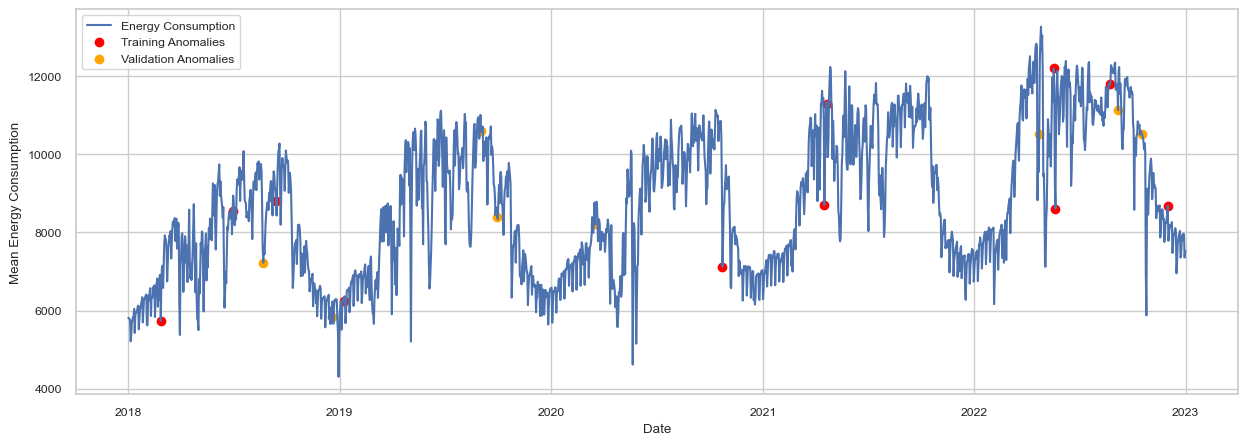

In [69]:

# Plot energy consumption data (mean across all hours)
daily_data['mean_energy'] = daily_data.iloc[:, 0:24].mean(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(daily_data.index, daily_data['mean_energy'], label='Energy Consumption')

# Mark the anomalies in the training set
train_anomalies_dates = daily_data.index[train_anomalies_indices]
plt.scatter(train_anomalies_dates, daily_data.loc[train_anomalies_dates, 'mean_energy'], color='red', label='Training Anomalies')

# Mark the anomalies in the validation set
val_anomalies_dates = daily_data.index[val_anomalies_indices]
plt.scatter(val_anomalies_dates, daily_data.loc[val_anomalies_dates, 'mean_energy'], color='orange', label='Validation Anomalies')

plt.xlabel('Date')
plt.ylabel('Mean Energy Consumption')
plt.legend()
plt.show()


In [70]:
train_anomalies_dates = daily_data.index[train_anomalies_indices]
val_anomalies_dates = daily_data.index[val_anomalies_indices]

In [71]:
daily_data.columns


Index([                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,                  10,                  11,
                        12,                  13,                  14,
                        15,                  16,                  17,
                        18,                  19,                  20,
                        21,                  22,                  23,
                 'cluster',             'month',           'Holiday',
                 'weekday',           'weekend',   'season_Business',
       'season_Irrigation',     'season_Summer',     'season_Winter',
             'mean_energy'],
      dtype='object')

In [72]:
train_anomalies_dates

DatetimeIndex(['2018-02-26', '2022-12-01', '2022-08-23', '2020-10-23',
               '2021-04-17', '2021-04-21', '2018-09-13', '2019-01-08',
               '2022-05-21', '2018-06-30', '2022-05-18'],
              dtype='datetime64[ns]', freq=None)

In [73]:
# Display the anomalies with the context columns
context_columns = ['cluster', 'month', 'weekday', 'weekend',  'Holiday', 'season_Business',
       'season_Irrigation',     'season_Summer',     'season_Winter']
anomalies_data = daily_data.loc[np.concatenate([train_anomalies_dates, val_anomalies_dates]), context_columns]

print("Anomalies with context:")
print(anomalies_data)


Anomalies with context:
            cluster  month  weekday  weekend  Holiday  season_Business  \
2018-02-26        0      2        0        1        0                0   
2022-12-01        0     12        3        1        0                0   
2022-08-23        1      8        1        1        1                1   
2020-10-23        0     10        4        0        0                0   
2021-04-17        0      4        5        0        0                0   
2021-04-21        1      4        2        1        0                0   
2018-09-13        0      9        3        1        0                1   
2019-01-08        0      1        1        1        0                0   
2022-05-21        0      5        5        0        0                0   
2018-06-30        0      6        5        0        0                0   
2022-05-18        1      5        2        1        0                0   
2019-09-02        1      9        0        1        0                1   
2022-09-06    

In [74]:
context_columns = ['cluster', 'month', 'weekday', 'weekend', 'Holiday', 'season_Business', 'season_Irrigation', 'season_Summer', 'season_Winter']
context_counts = anomalies_data[context_columns].groupby(context_columns).size().reset_index(name='count')
print(context_counts)


    cluster  month  weekday  weekend  Holiday  season_Business  \
0         0      1        1        1        0                0   
1         0      2        0        1        0                0   
2         0      3        1        1        1                0   
3         0      4        5        0        0                0   
4         0      5        5        0        0                0   
5         0      6        5        0        0                0   
6         0      8        2        1        0                1   
7         0      9        0        1        0                1   
8         0      9        3        1        0                1   
9         0     10        4        0        0                0   
10        0     12        1        1        0                0   
11        0     12        3        1        0                0   
12        1      4        2        1        0                0   
13        1      4        5        0        0                0   
14        

1. Cluster 0 has more anomalies (12) than Cluster 1 (7). This suggests that the consumption patterns in Cluster 0 might be more prone to anomalies or that the autoencoder is more sensitive to detecting anomalies in Cluster 0.
2. There is no specific month with a high concentration of anomalies. Anomalies occur in different months, although some months like April, September, and December have multiple anomalies. This may indicate that certain periods or events within these months could contribute to anomalous consumption patterns.
3. Most anomalies occur on weekdays (10) rather than weekends (9). This could be related to variations in consumption patterns during the workweek, which may be different from the patterns observed during weekends.
4. Most anomalies occur on non-holiday days (17) compared to holiday days (2). This suggests that the consumption patterns on regular days might be more susceptible to anomalies.
5. The anomalies are spread across different seasons, with the highest number in the Irrigation season (8) and the Business season (6). This could be due to varying water demand patterns during these seasons.


In [75]:
# Group the anomalies by cluster and calculate the mean values for each feature
cluster_means = anomalies_data.groupby('cluster').mean()

# Print the mean values for each feature, grouped by cluster
print(cluster_means)

         month  weekday  weekend  Holiday  season_Business  season_Irrigation  \
cluster                                                                         
0         6.75     2.50     0.67     0.08             0.25               0.33   
1         7.00     1.57     0.86     0.29             0.43               0.43   

         season_Summer  season_Winter  
cluster                                
0                 0.08           0.25  
1                 0.00           0.00  


We can make the following observations about the differences between the two clusters:

**month:** Cluster 0 has a slightly lesser mean month value (6.75) than Cluster 1 (7.00). This indicates that anomalies in Cluster 1 are more likely to occur later in the year compared to those in Cluster 0.

**weekday:** Cluster 0 has a higher mean weekday value (2.50) than Cluster 1 (1.57). This suggests that anomalies in Cluster 0 tend to occur later in the week compared to those in Cluster 1.

**weekend:** Cluster 0 has a lower mean weekend value (0.67) than Cluster 1 (0.86). This indicates that anomalies in Cluster 0 are less likely to occur on weekends compared to Cluster 1.

**Holiday:** Cluster 0 has a lower mean Holiday value (0.08) than Cluster 1 (0.43). This suggests that anomalies in Cluster 0 are less likely to occur on holidays compared to Cluster 1.

**season_Business:** The mean value for Cluster 0 (0.25) is lower than for Cluster 1 (0.43). This indicates that anomalies in Cluster 0 are less likely to occur in the business season compared to Cluster 1.

**season_Irrigation:** Both clusters have similar mean values (0.33 for Cluster 0 and 0.43 for Cluster 1). This suggests that there is no significant difference in the occurrence of anomalies during the irrigation season between the two clusters.

**season_Summer:** Both clusters have a mean value of 0.04, indicating that anomalies in both clusters are not more likely to occur in the summer season.

**season_Winter:** Cluster 0 has a higher mean winter value (0.25) compared to Cluster 1 (0.00). This indicates that anomalies in Cluster 0 are more likely to occur in the winter season compared to Cluster 1.

In summary, the analysis of the two clusters reveals differences in the occurrence of anomalies with respect to factors such as month, weekday, weekend, holidays, and seasonal characteristics. Cluster 1 has more anomalies than Cluster 0 and exhibits a higher likelihood of anomalies occurring later in the year, later in the week, and during the winter season, weekends and holidays and during the business season.

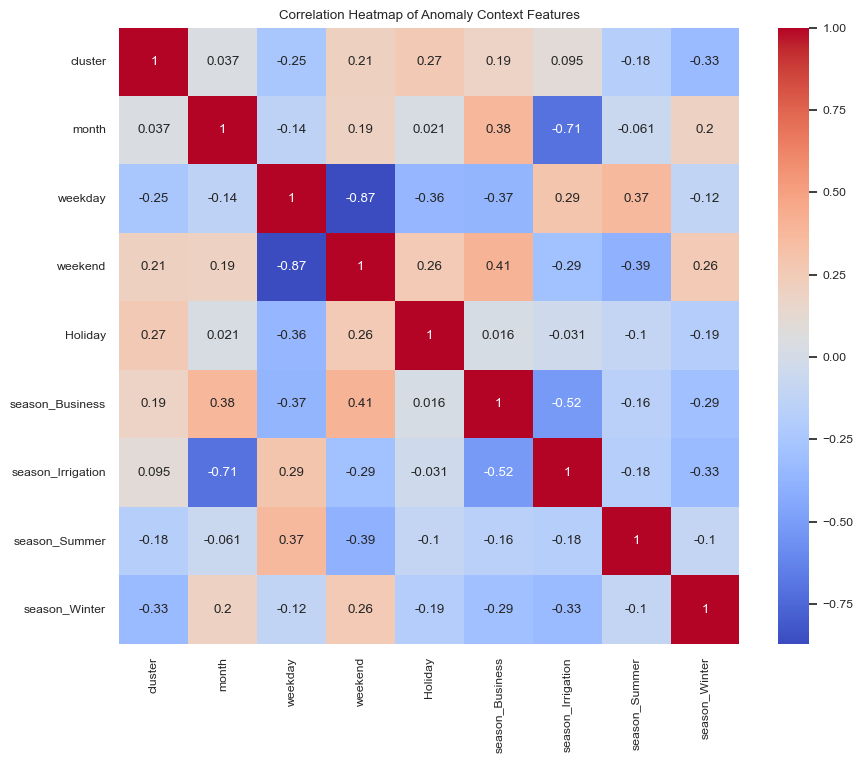

In [76]:
# Calculate correlations between context columns
context_corr = anomalies_data[context_columns].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(context_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Anomaly Context Features")
plt.show()


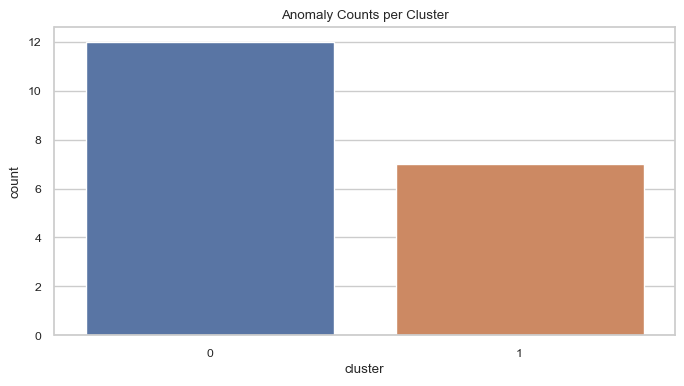

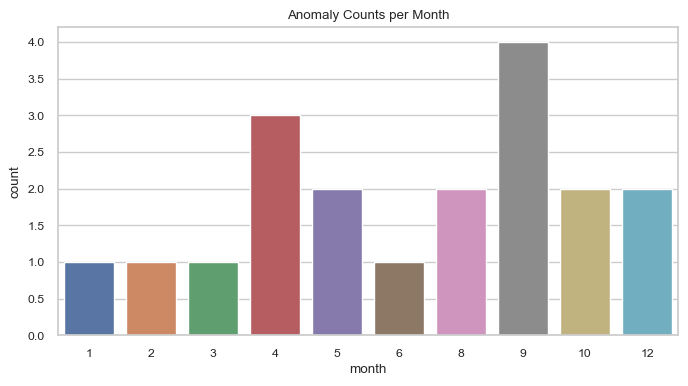

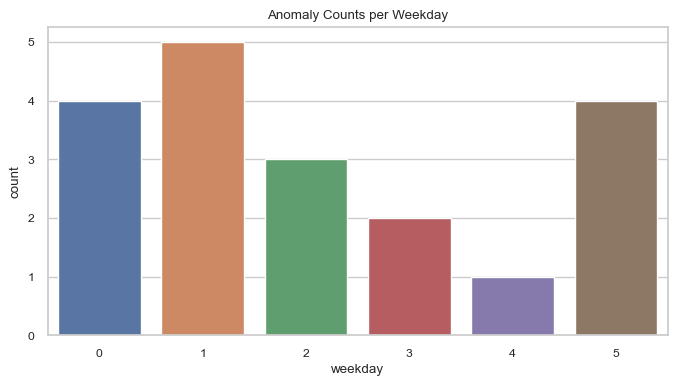

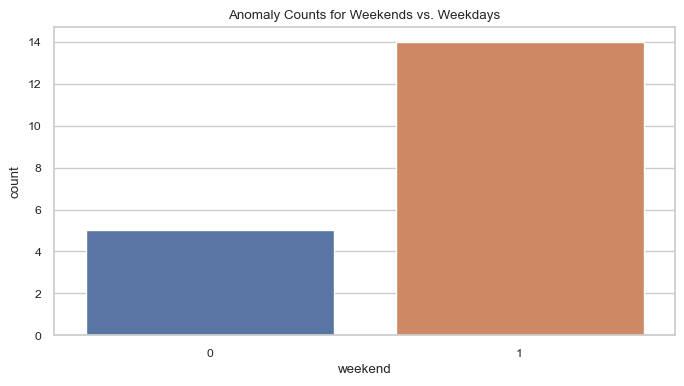

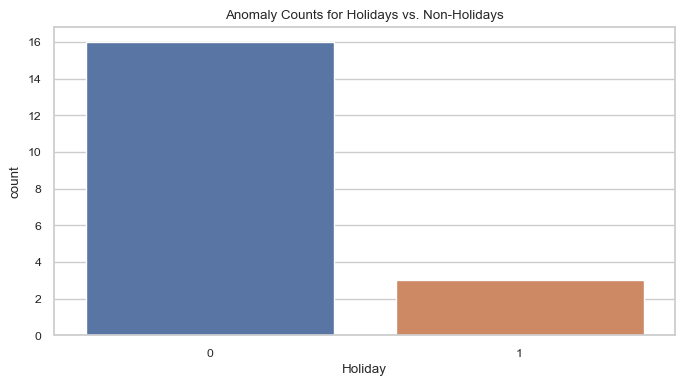

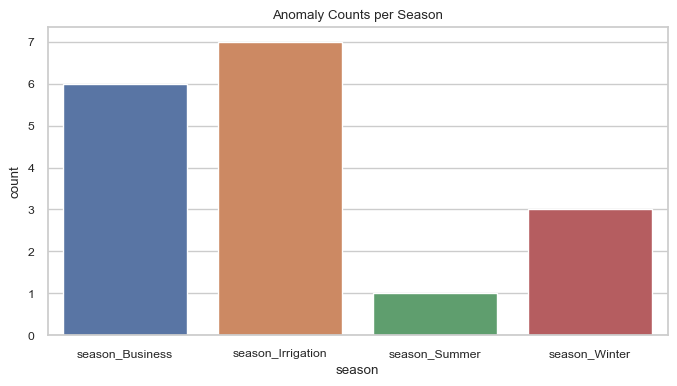

In [77]:

# Anomaly counts per cluster
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='cluster')
plt.title('Anomaly Counts per Cluster')
plt.show()

# Anomaly counts per month
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='month')
plt.title('Anomaly Counts per Month')
plt.show()

# Anomaly counts per weekday
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='weekday')
plt.title('Anomaly Counts per Weekday')
plt.show()

# Anomaly counts per weekend
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='weekend')
plt.title('Anomaly Counts for Weekends vs. Weekdays')
plt.show()

# Anomaly counts per holiday
plt.figure(figsize=(8, 4))
sns.countplot(data=anomalies_data, x='Holiday')
plt.title('Anomaly Counts for Holidays vs. Non-Holidays')
plt.show()

# Anomaly counts per season-related columns
season_columns = ['season_Business', 'season_Irrigation', 'season_Summer', 'season_Winter']
season_counts = anomalies_data[season_columns].sum().reset_index(name='count')
season_counts.columns = ['season', 'count']

plt.figure(figsize=(8, 4))
sns.barplot(data=season_counts, x='season', y='count')
plt.title('Anomaly Counts per Season')
plt.show()


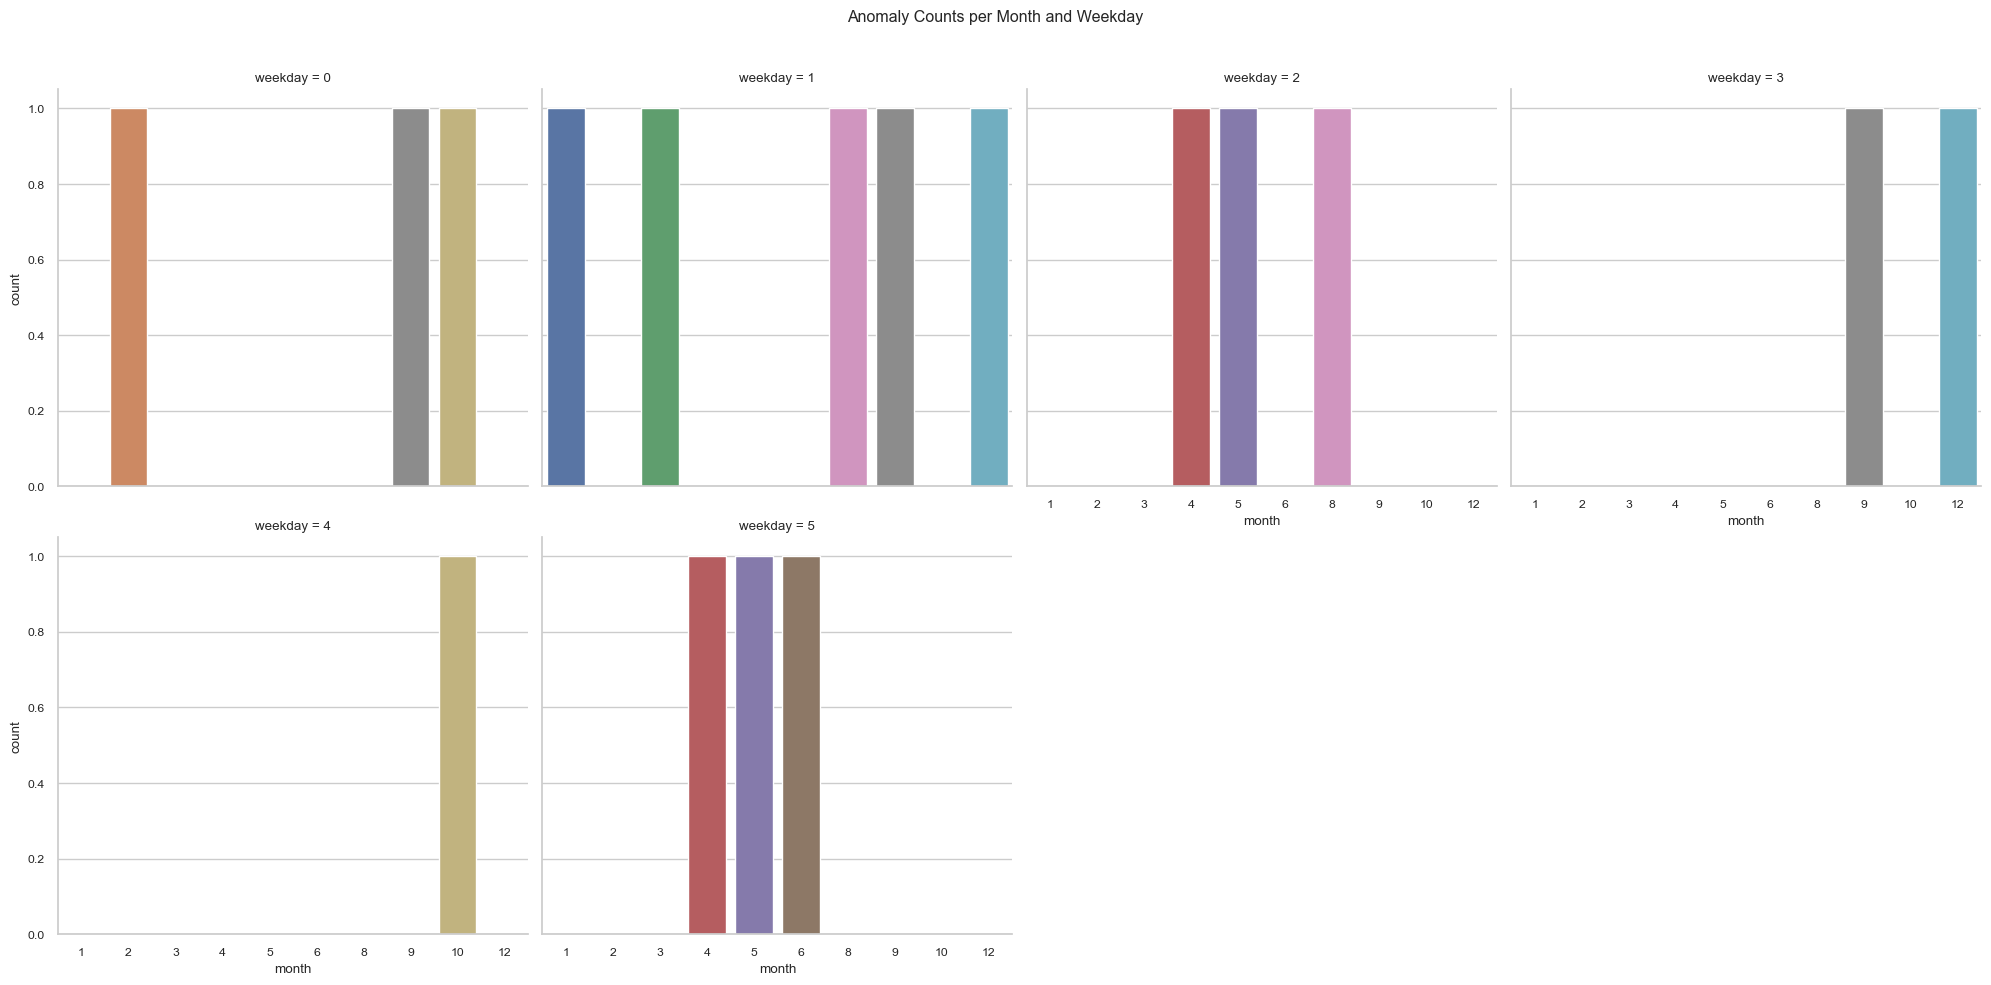

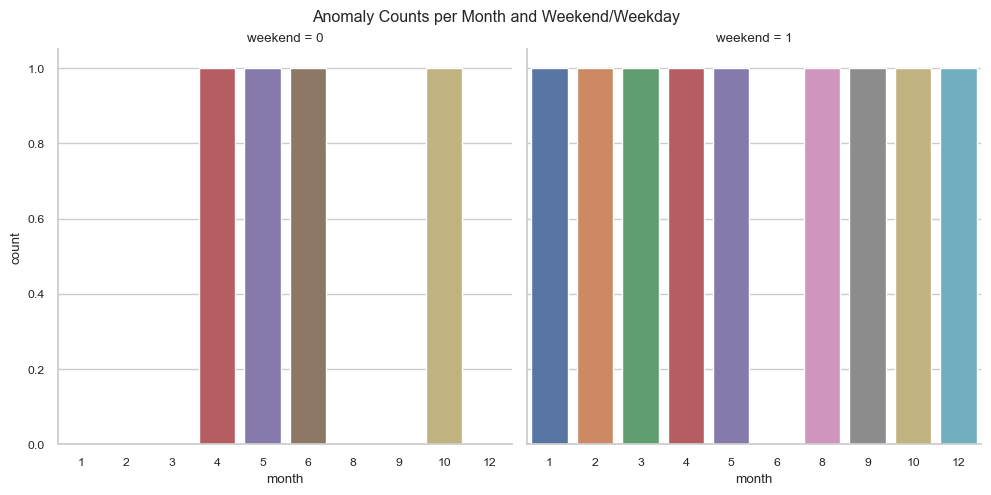

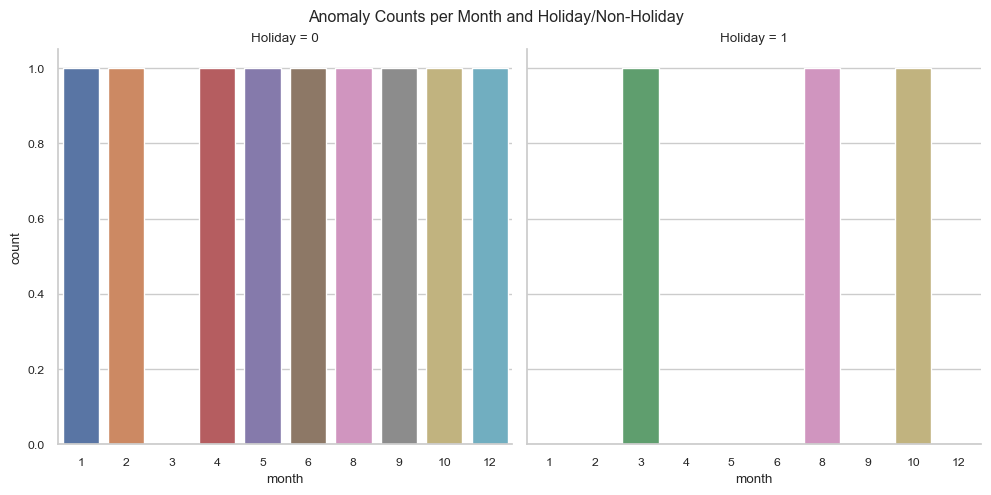

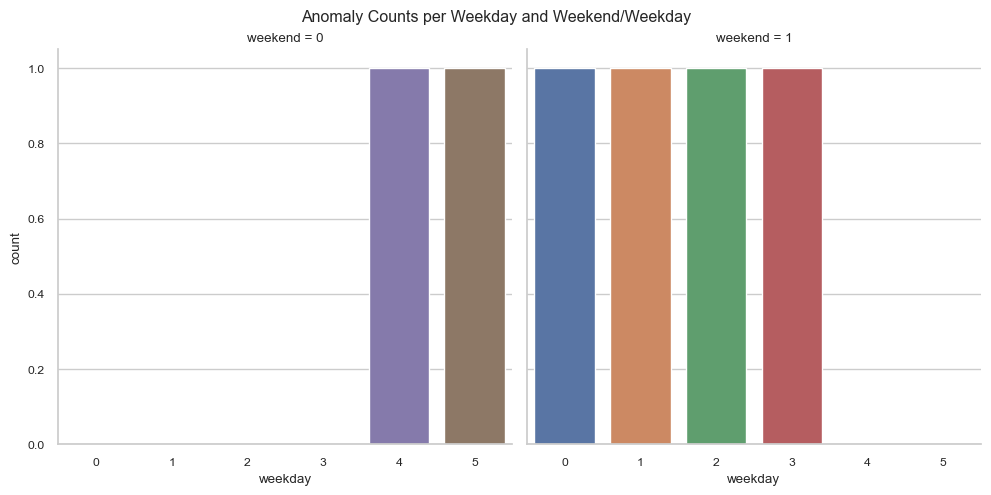

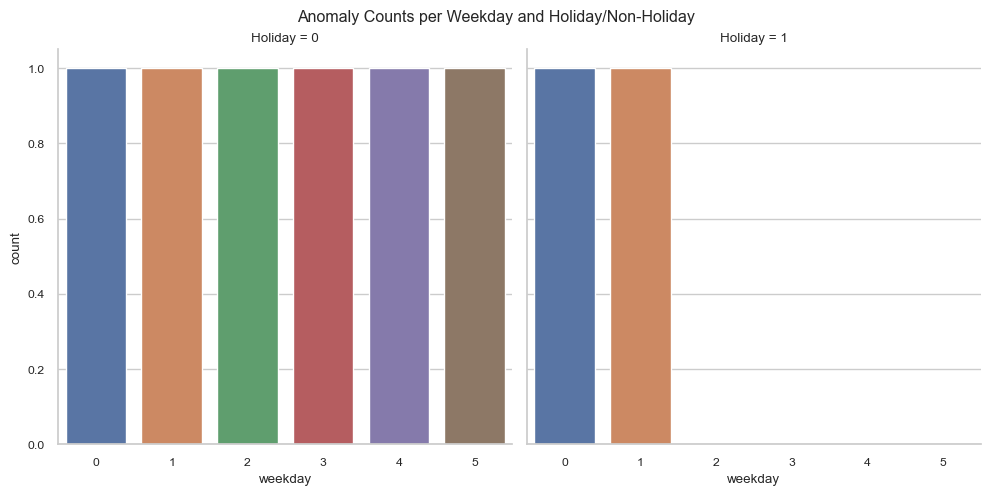

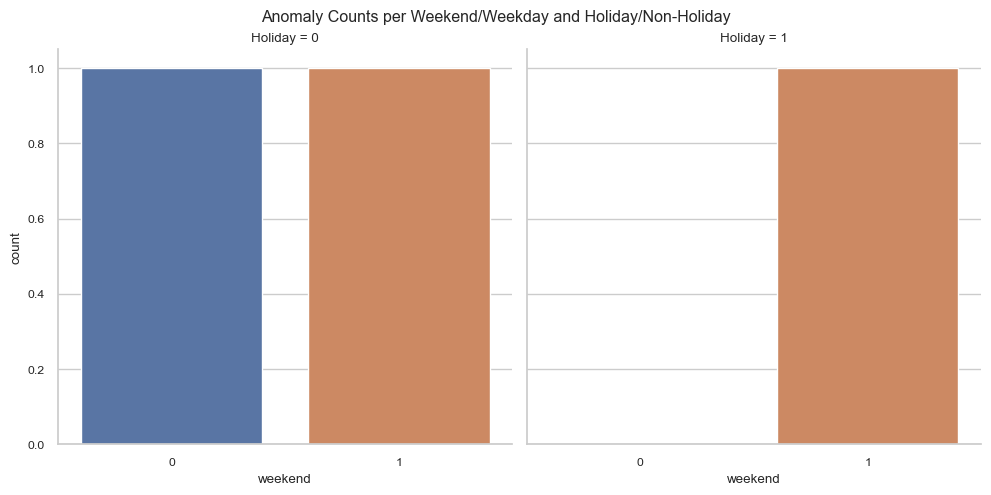

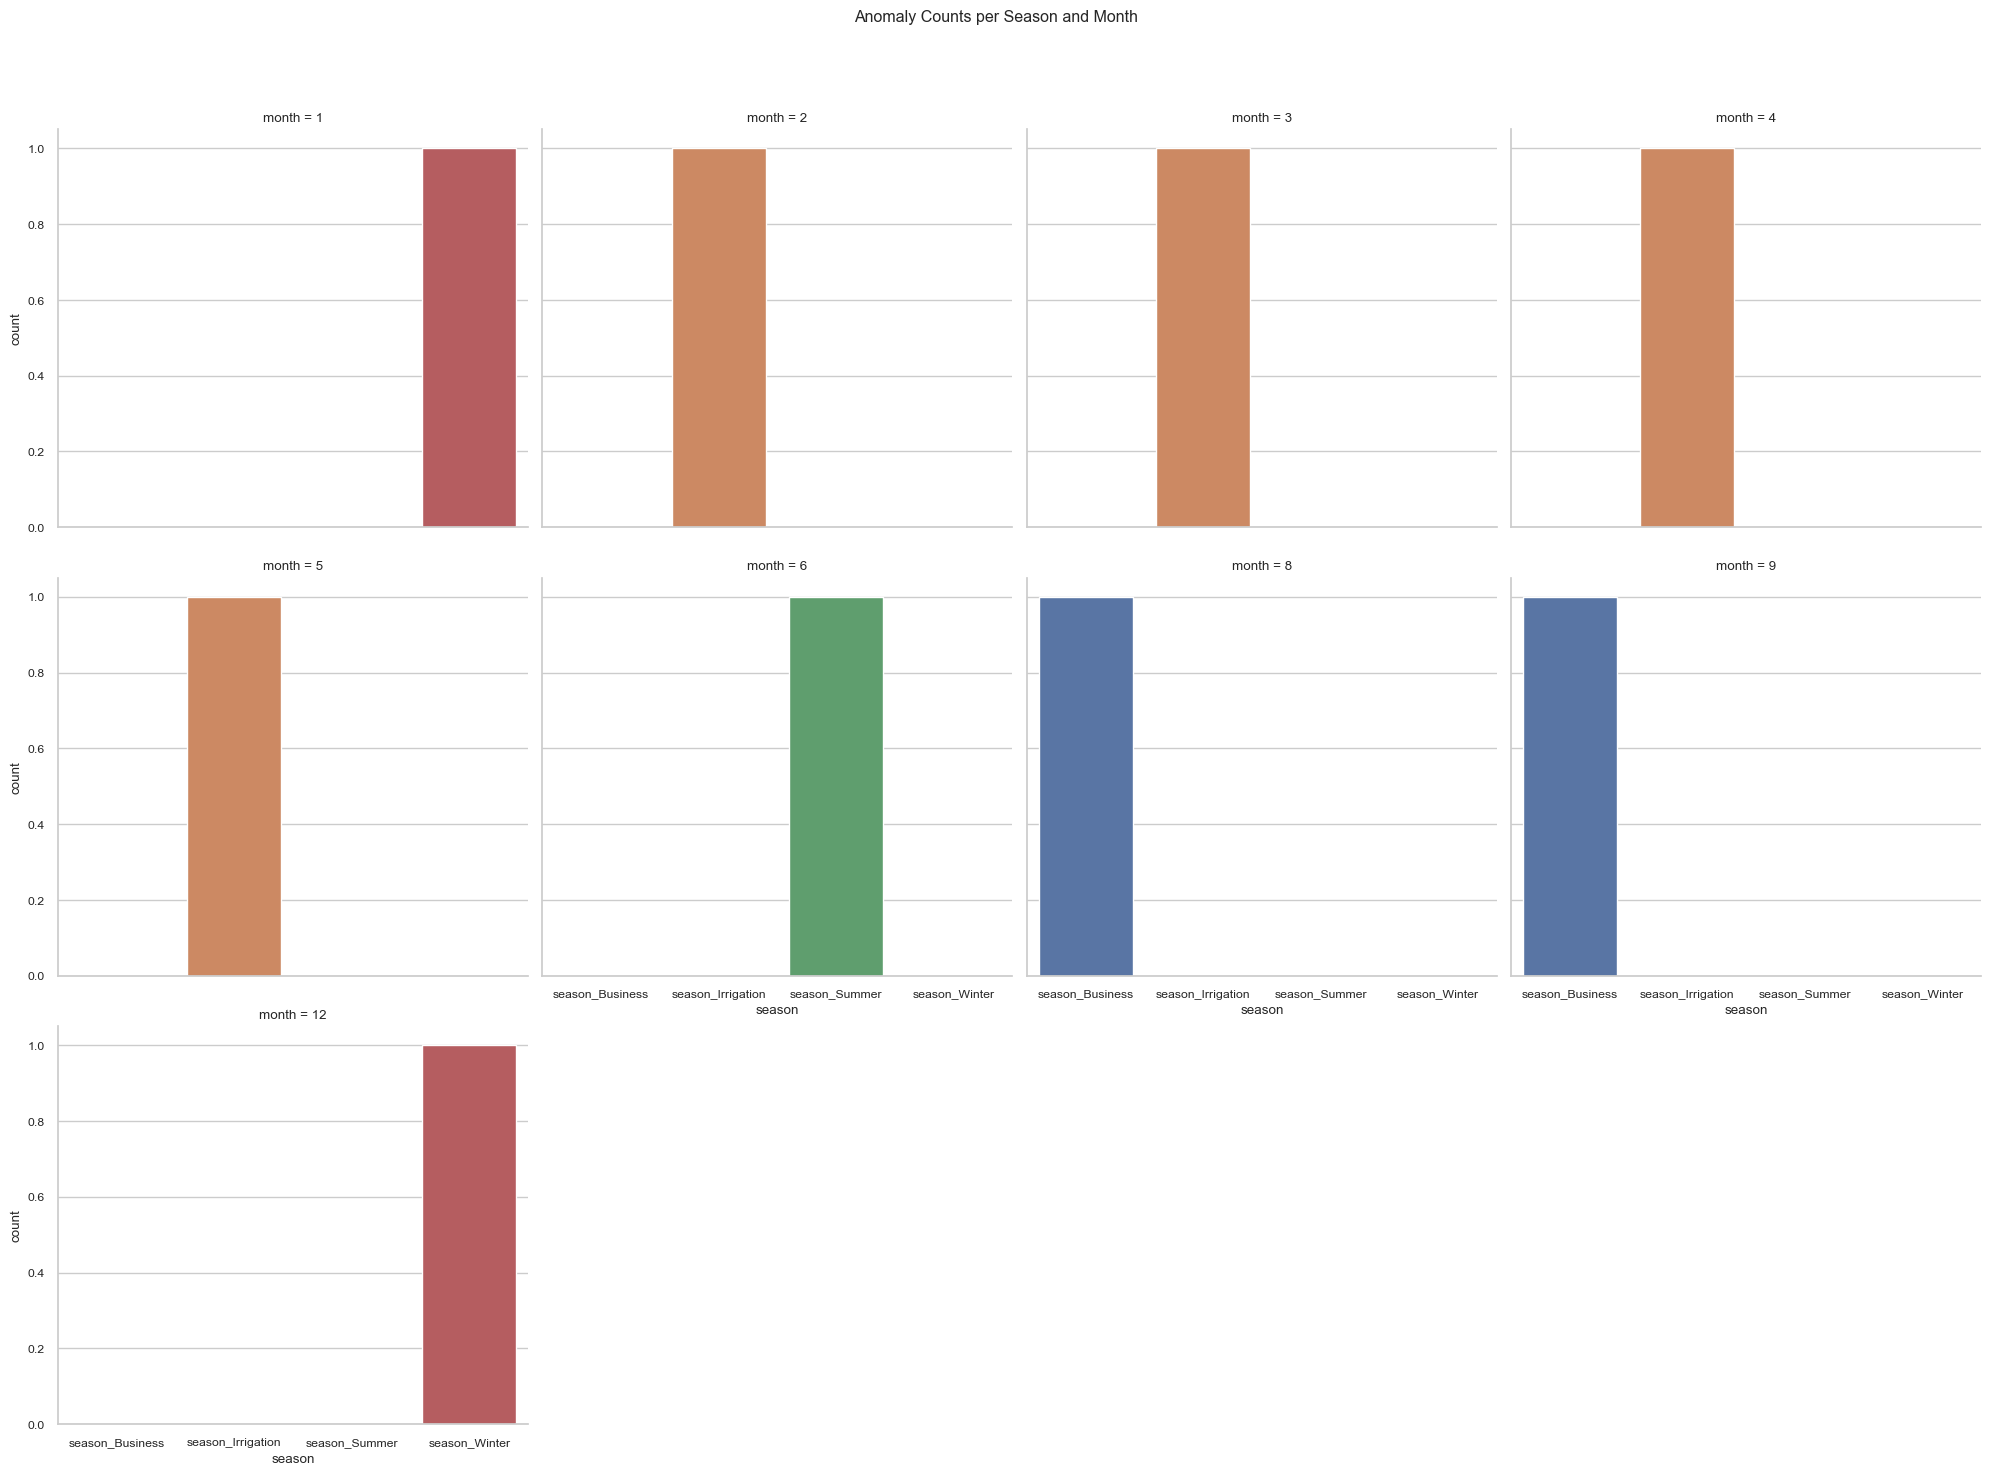

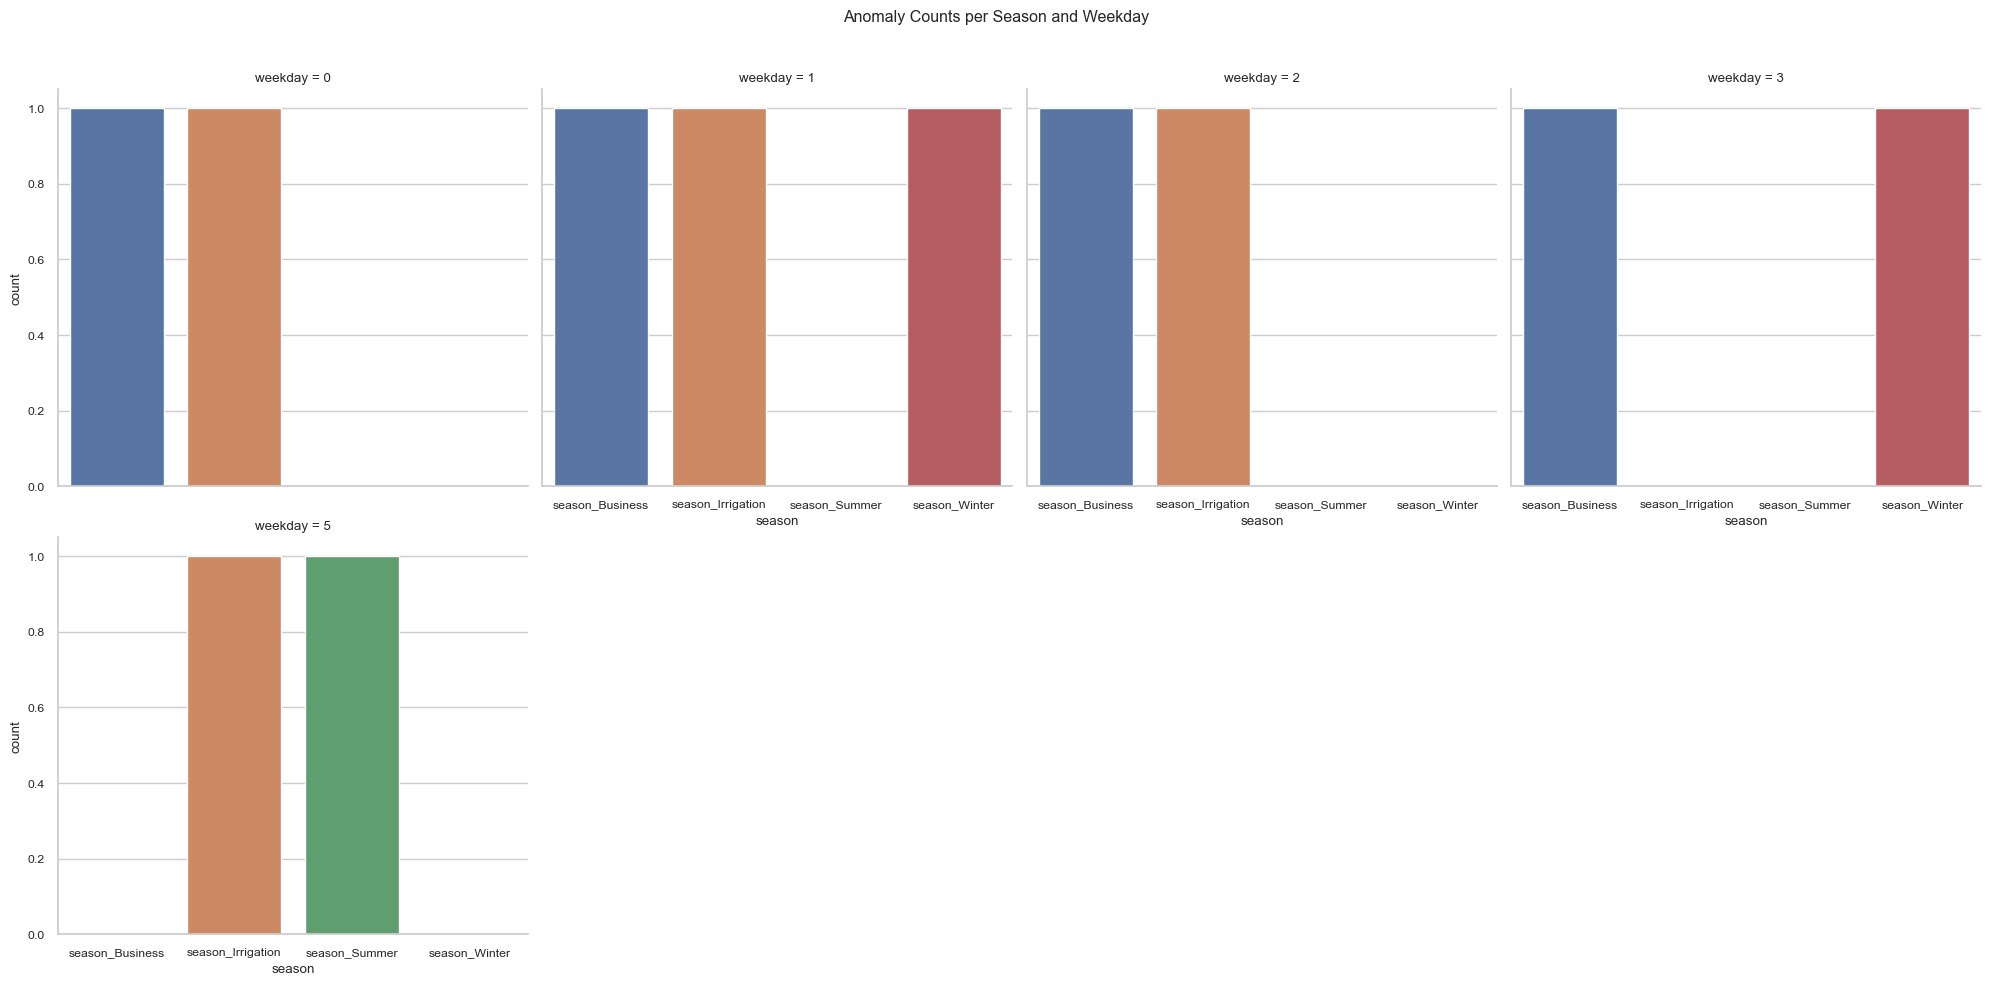

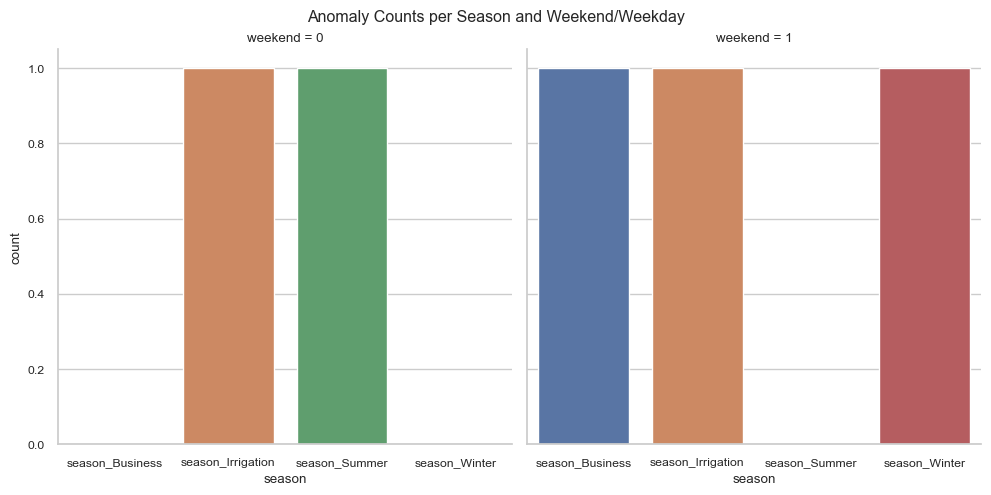

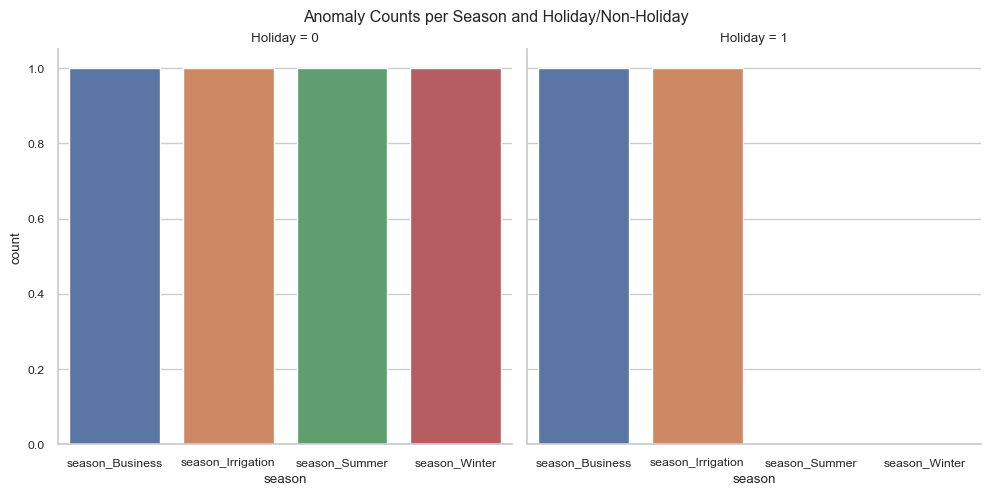

In [78]:
# Relationship between month and other context columns
sns.catplot(data=context_counts, x='month', y='count', col='weekday', kind='bar', col_wrap=4)
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Month and Weekday')
plt.show()

sns.catplot(data=context_counts, x='month', y='count', col='weekend', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Month and Weekend/Weekday')
plt.show()

sns.catplot(data=context_counts, x='month', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Month and Holiday/Non-Holiday')
plt.show()

# Relationship between weekday and other context columns
sns.catplot(data=context_counts, x='weekday', y='count', col='weekend', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Weekday and Weekend/Weekday')
plt.show()

sns.catplot(data=context_counts, x='weekday', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Weekday and Holiday/Non-Holiday')
plt.show()

# Relationship between weekend and other context columns
sns.catplot(data=context_counts, x='weekend', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Weekend/Weekday and Holiday/Non-Holiday')
plt.show()

# Relationship between season and other context columns
season_columns = ['season_Business', 'season_Irrigation', 'season_Summer', 'season_Winter']
season_df = anomalies_data.melt(id_vars=['cluster','month','weekday','weekend','Holiday'], value_vars=season_columns, var_name='season', value_name='count').query("count == 1")

sns.catplot(data=season_df, x='season', y='count', col='month', kind='bar', col_wrap=4)
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Month')
plt.show()

sns.catplot(data=season_df, x='season', y='count', col='weekday', kind='bar', col_wrap=4)
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Weekday')
plt.show()

sns.catplot(data=season_df, x='season', y='count', col='weekend', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Weekend/Weekday')
plt.show()

sns.catplot(data=season_df, x='season', y='count', col='Holiday', kind='bar')
plt.subplots_adjust(top=0.9)
plt.suptitle('Anomaly Counts per Season and Holiday/Non-Holiday')
plt.show()


**Seasonal demand patterns:** Bangladesh has distinct seasonal variations, with summer being the hottest and most humid period. People tend to use more electricity during summer for cooling purposes, which may lead to higher energy consumption and potential anomalies.

**Hypothesis 1:** Anomalies in energy consumption are more likely to occur during summer due to increased demand for cooling.

**Industrial and agricultural activities:** The energy consumption patterns of the industrial and agricultural sectors can influence the overall energy consumption. For example, irrigation activities usually increase during certain periods, which may lead to higher energy consumption.

**Hypothesis 2:** Anomalies in energy consumption might be associated with periods of high industrial or agricultural activities.

**Holidays and special events:** Energy consumption may vary during holidays and special events due to changes in people's daily routines and commercial activities. For instance, during religious festivals, there could be increased energy consumption due to celebrations, gatherings, and lighting.

**Hypothesis 3:** Anomalies in energy consumption might be related to holidays or special events.

**Infrastructure and maintenance issues:** Power plants and energy infrastructure may experience maintenance issues or capacity constraints, which could lead to temporary changes in energy consumption patterns.

**Hypothesis 4:** Anomalies in energy consumption might be associated with infrastructure or maintenance issues.

**Weather-related factors:** Extreme weather conditions, such as storms, floods, or heatwaves, can affect energy consumption patterns. For example, during a heatwave, people may use more electricity for cooling, leading to higher energy consumption.